<a href="https://colab.research.google.com/github/HowonRyu/ConfidenceSet/blob/main/ConfidenceSet_Demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize

To add:
confidence set simulation -> make it into function

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import Normalize
import random
import sys
import os
import math
import scipy.stats
import pickle

#!rm -rf ConfSets
#!git clone https://github.com/TomMaullin/ConfSets.git
#sys.path.append('/content/ConfSets/lib/')
#from generateData import *
#from boundary import *

!pip install git+https://github.com/HowonRyu/ConfidenceSet.git
from confidenceset.random_field_generator import *
from confidenceset.confset import *
from confidenceset.plot import *
from confidenceset.test import *
from confidenceset.simulation import *

%load_ext autoreload
%autoreload 2

  Cloning https://github.com/HowonRyu/ConfidenceSet.git to /private/var/folders/ly/8p16t5q955n0ptfrv1_8_r8m0000gn/T/pip-req-build-k6zi941k
  Running command git clone --filter=blob:none --quiet https://github.com/HowonRyu/ConfidenceSet.git /private/var/folders/ly/8p16t5q955n0ptfrv1_8_r8m0000gn/T/pip-req-build-k6zi941k
  Resolved https://github.com/HowonRyu/ConfidenceSet.git to commit 43f669d88d03a85f3165ec050f1901306882bc1c
  Preparing metadata (setup.py) ... done
  Created wheel for confidenceset: filename=confidenceset-0.0.2-py3-none-any.whl size=18456 sha256=b7023c911aebfb9c0eb66cab26af975c9822ec804ab09b574052518bc42f8346
  Stored in directory: /private/var/folders/ly/8p16t5q955n0ptfrv1_8_r8m0000gn/T/pip-ephem-wheel-cache-5pt5ggyz/wheels/ff/40/a3/2e98c05b8a9865e6f9e38fc1befbf42781f18284891f14ff25
Successfully built confidenceset


Defining specs for the shape

In [16]:
dim_100 = (80,100,100)
dim_50 = (80, 50, 50)


spec_50, spec_100 = gen_spec(fwhm_sig=10, fwhm_noise=0, std=5, mag=4, r=0.5)
spec_50_sig20, spec_100_sig20 = gen_spec(fwhm_sig=20, fwhm_noise=0, std=5, mag=4, r=0.5)
spec_50_noise10, spec_100_noise10 = gen_spec(fwhm_sig=10, fwhm_noise=10, std=5, mag=4, r=0.5)
spec_50_noise20, spec_100_noise20 = gen_spec(fwhm_sig=10, fwhm_noise=20, std=5, mag=4, r=0.5)

# for plot functions
shape_specs_50 = [spec_50, spec_50_sig20, spec_50_noise10, spec_50_noise20]
shape_specs_100 = [spec_100, spec_100_sig20, spec_100_noise10, spec_100_noise20]
shape_specs_sim = [shape_specs_50, shape_specs_100]

# for signal plotting
spec_cir_50, spec_elp_50, spec_ramp_50 = spec_50
spec_cir_100, spec_elp_100, spec_ramp_100 = spec_100

spec_cir_50_smth, spec_elp_50_smth, spec_ramp_50_smth = spec_50_noise10
spec_cir_100_smth, spec_elp_100_smth, spec_ramp_100_smth = spec_100_noise10

# FDR Confidence Set



\begin{array}{|c|c|} \hline
 & N & P &  \\ \hline
H_0 & TN & FP & m_0 \\
H_1 & FN & TP & m-m_0 \\ \hline
 & m-R & R & m \\ \hline
\end{array}


**Family Wise Error Rate (FWER)**
*   $FWER = P(FP \ge 1 | H_0)$
*   In multiple testing, use Bonferroni to control for: $FWER <\frac{\alpha}{m}$



**False Discovery Rate (FDR)**

*   $FDR = E(\frac{FP}{R} | R>0)P(R>0) = E \frac{FP}{\max(1,R)} $
*  ((If you can add BH proof))

## Signals and Confidence Sets

Different settings of image size and variance

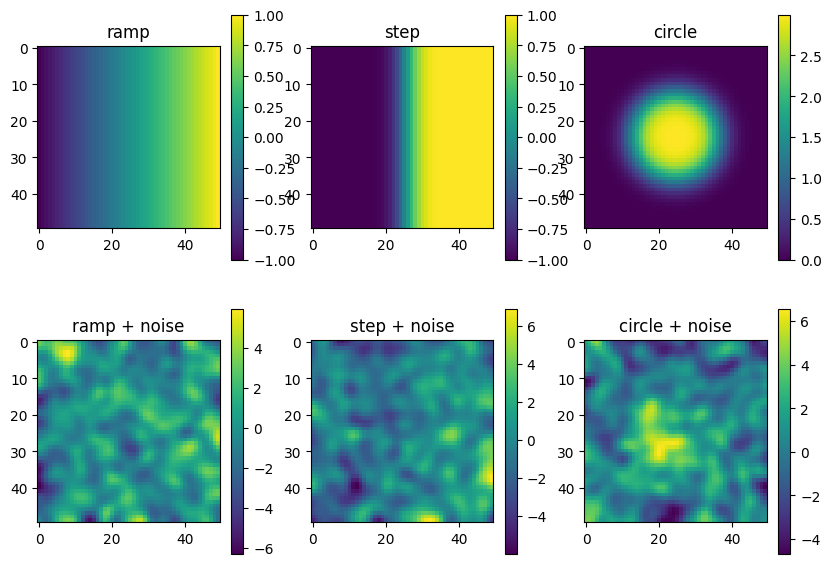

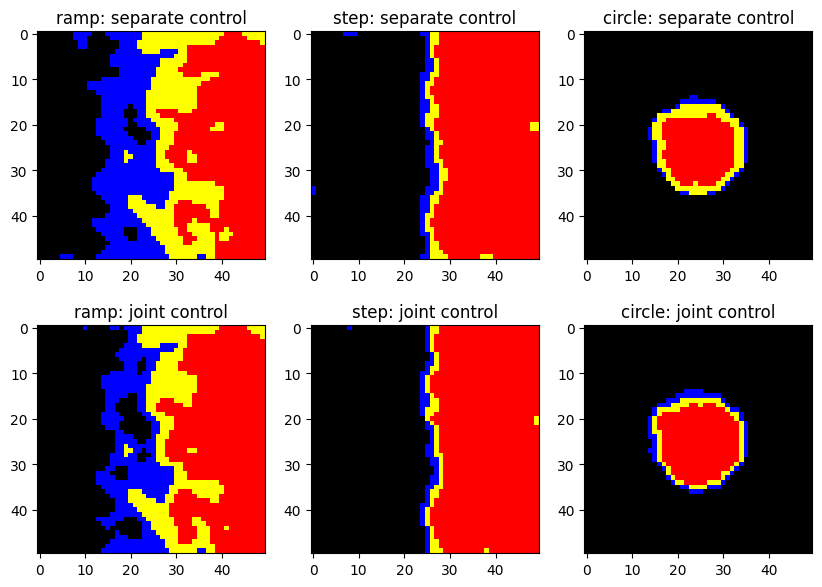

In [21]:
# signal + noise plots
signal_smth = 8
noise_smth = 4
std = 1.5

ramp_spec = {'direction': 1,
                  'mag':(-1,1),
                  'fwhm_noise': noise_smth,
               'std': std}

step_spec = {'fwhm_noise': noise_smth,
             'fwhm_signal' : signal_smth,
             'std': std}

circle_spec = {'r':0.5, 'mag':3,
                  'fwhm_signal': signal_smth,
                  'fwhm_noise': noise_smth,
                  'std': std}

ramp, ramp_mu = gen_2D((80,50,50), shape="ramp", shape_spec = ramp_spec)
step, step_mu = gen_2D((80,50,50), shape="step", shape_spec = step_spec)
circle, circle_mu = gen_2D((80,50,50), shape="circle", shape_spec = circle_spec)

fontsize = 12
figsize = (10, 7)

fig, axs = plt.subplots(2, 3, figsize=figsize)
im = axs[0,0].imshow(ramp_mu)
axs[0,0].set_title("ramp", fontsize = fontsize)
fig.colorbar(im, ax=axs[0, 0])

im = axs[0,1].imshow(step_mu)
axs[0,1].set_title("step", fontsize = fontsize)
fig.colorbar(im, ax=axs[0, 1])


im = axs[0,2].imshow(circle_mu)
axs[0,2].set_title("circle", fontsize = fontsize)
fig.colorbar(im, ax=axs[0, 2])


im = axs[1,0].imshow(ramp[0,:,:])
axs[1,0].set_title("ramp + noise", fontsize = fontsize)
fig.colorbar(im, ax=axs[1, 0])

im = axs[1,1].imshow(step[0,:,:])
axs[1,1].set_title("step + noise", fontsize = fontsize)
fig.colorbar(im, ax=axs[1, 1])

im = axs[1,2].imshow(circle[0,:,:])
axs[1,2].set_title("circle + noise", fontsize = fontsize)
fig.colorbar(im, ax=axs[1, 2])
plt.show()


# confset plot

ramp_lower, ramp_upper, ramp_Achat, _, _ = fdr_confset(data=ramp, threshold=0, method="separate_adaptive", alpha=0.05,
             k=2, alpha0=0.05 / 4, alpha1=0.05 / 2)

step_lower, step_upper, step_Achat, _, _ = fdr_confset(data=step, threshold=0, method="separate_adaptive", alpha=0.05,
             k=2, alpha0=0.05 / 4, alpha1=0.05 / 2)
circle_lower, circle_upper, circle_Achat, _, _ = fdr_confset(data=circle, threshold=2, method="separate_adaptive", alpha=0.05,
             k=2, alpha0=0.05 / 4, alpha1=0.05 / 2)

ramp_lower2, ramp_upper2, ramp_Achat2, _, _ = fdr_confset(data=ramp, threshold=0, method="joint", alpha=0.1,
             k=2, alpha0=0.1 / 4, alpha1=0.1 / 2)

step_lower2, step_upper2, step_Achat2, _, _ = fdr_confset(data=step, threshold=0, method="joint", alpha=0.1,
             k=2, alpha0=0.1 / 4, alpha1=0.1 / 2)
circle_lower2, circle_upper2, circle_Achat2, _, _ = fdr_confset(data=circle, threshold=2, method="joint", alpha=0.1,
             k=2, alpha0=0.1 / 4, alpha1=0.1 / 2)




fig, axs = plt.subplots(2, 3, figsize=figsize)
cmap1 = colors.ListedColormap(['black', 'blue'])
cmap2 = colors.ListedColormap(['none', 'yellow'])
cmap3 = colors.ListedColormap(['none', 'red'])

im = axs[0,0].imshow(ramp_lower, cmap=cmap1)
im = axs[0,0].imshow(ramp_Achat, cmap=cmap2)
im = axs[0,0].imshow(ramp_upper, cmap=cmap3)
axs[0,0].set_title("ramp: separate control", fontsize = fontsize)

im = axs[0,1].imshow(step_lower, cmap=cmap1)
im = axs[0,1].imshow(step_Achat, cmap=cmap2)
im = axs[0,1].imshow(step_upper, cmap=cmap3)
axs[0,1].set_title("step: separate control", fontsize = fontsize)

im = axs[0,2].imshow(circle_lower, cmap=cmap1)
im = axs[0,2].imshow(circle_Achat, cmap=cmap2)
im = axs[0,2].imshow(circle_upper, cmap=cmap3)
axs[0,2].set_title("circle: separate control", fontsize = fontsize)

im = axs[1,0].imshow(ramp_lower2, cmap=cmap1)
im = axs[1,0].imshow(ramp_Achat2, cmap=cmap2)
im = axs[1,0].imshow(ramp_upper2, cmap=cmap3)
axs[1,0].set_title("ramp: joint control", fontsize = fontsize)

im = axs[1,1].imshow(step_lower2, cmap=cmap1)
im = axs[1,1].imshow(step_Achat2, cmap=cmap2)
im = axs[1,1].imshow(step_upper2, cmap=cmap3)
axs[1,1].set_title("step: joint control", fontsize = fontsize)

im = axs[1,2].imshow(circle_lower2, cmap=cmap1)
im = axs[1,2].imshow(circle_Achat2, cmap=cmap2)
im = axs[1,2].imshow(circle_upper2, cmap=cmap3)
axs[1,2].set_title("circle: joint control", fontsize = fontsize)
plt.show()


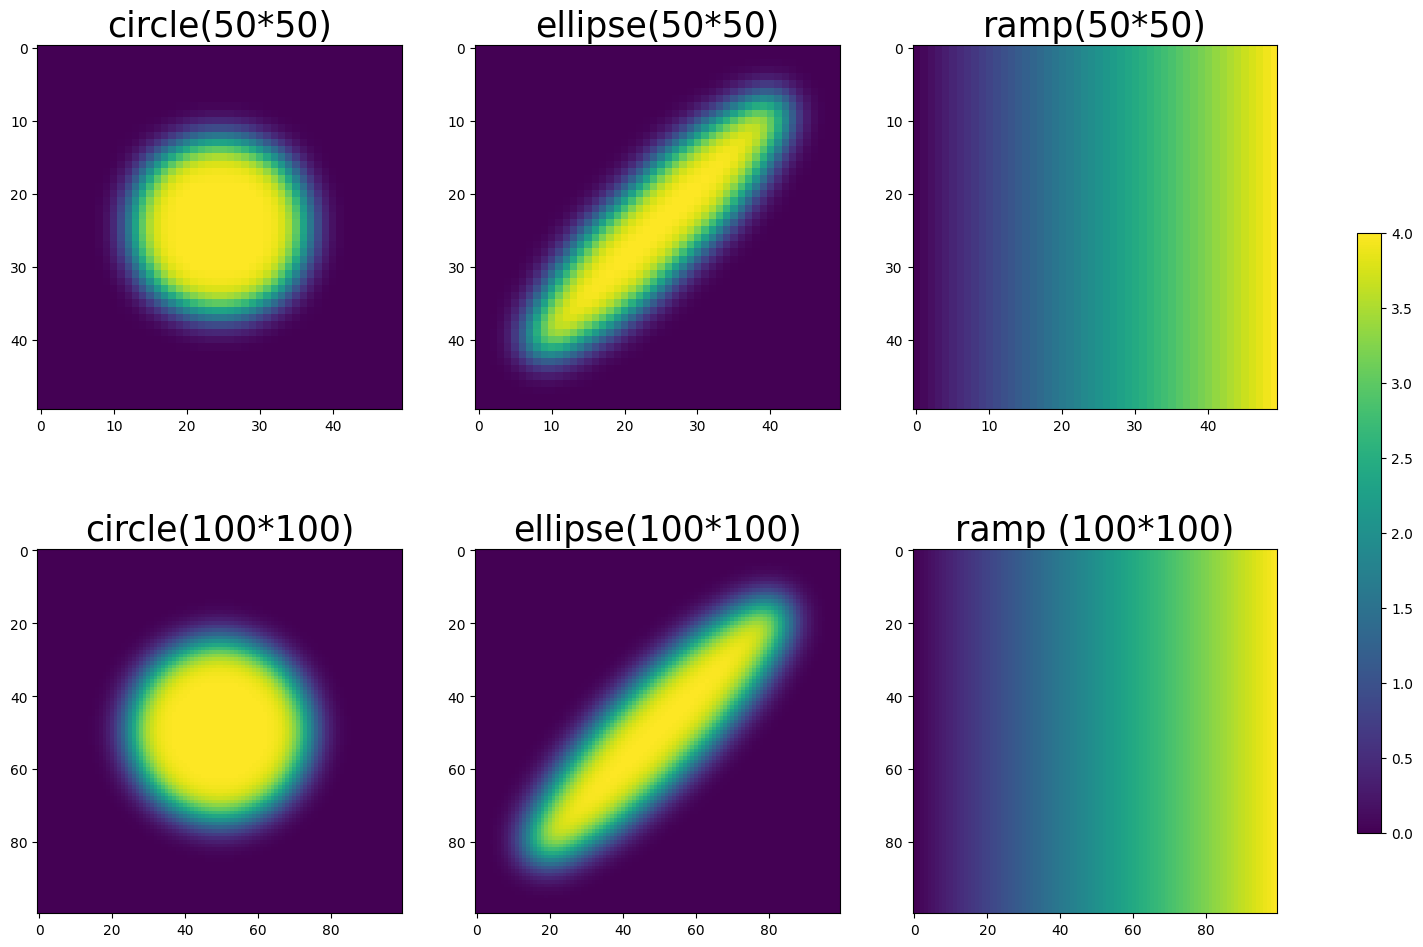

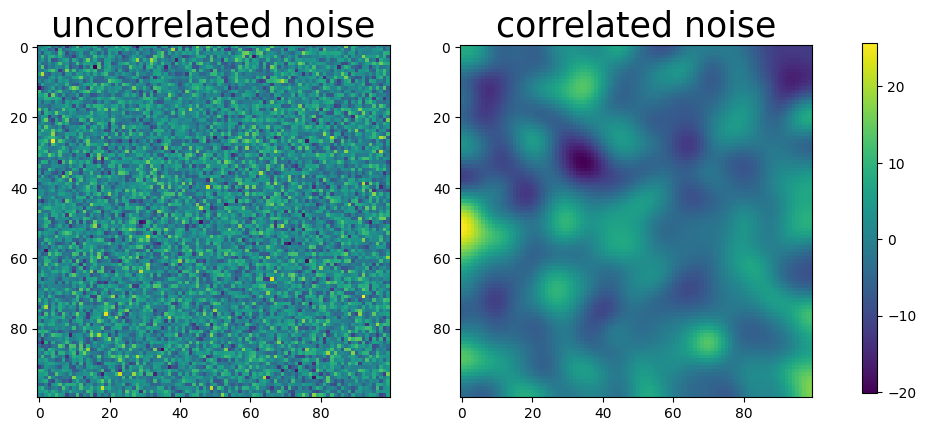

In [23]:
#random field generator

circular_50, mu_circular_50 = gen_2D(dim_50, shape="ellipse", shape_spec=spec_cir_50)
ellipse_50, mu_ellipse_50 = gen_2D(dim_50, shape="ellipse", shape_spec=spec_elp_50)
ramp_50, mu_ramp_50 = gen_2D(dim_50, shape="ramp", shape_spec=spec_ramp_50)
circular_100, mu_circular_100 = gen_2D(dim_100, shape="ellipse", shape_spec=spec_cir_100)
ellipse_100, mu_ellipse_100 = gen_2D(dim_100, shape="ellipse", shape_spec=spec_elp_100)
ramp_100, mu_ramp_100 = gen_2D(dim_100, shape="ramp", shape_spec=spec_ramp_100)


circular_50_smth, _ = gen_2D(dim_50, shape="ellipse", shape_spec=spec_cir_50_smth)
ellipse_50_smth, _ = gen_2D(dim_50, shape="ellipse", shape_spec=spec_elp_50_smth)
ramp_50_smth, _ = gen_2D(dim_50, shape="ramp", shape_spec=spec_ramp_50_smth)
circular_100_smth, _ = gen_2D(dim_100, shape="ellipse", shape_spec=spec_cir_100_smth)
ellipse_100_smth, _ = gen_2D(dim_100, shape="ellipse", shape_spec=spec_elp_100_smth)
ramp_100_smth, _ = gen_2D(dim_100, shape="ramp", shape_spec=spec_ramp_100_smth)



#plotting
fig, axs = plt.subplots(2, 3, figsize=(16, 12))
im = axs[0,0].imshow(mu_circular_50)
axs[0,0].set_title("circle(50*50)", fontsize = 25)
#plt.colorbar(im00, ax=axs[0, 0])

im = axs[0,1].imshow(mu_ellipse_50)
axs[0,1].set_title("ellipse(50*50)", fontsize = 25)
#plt.colorbar(im01, ax=axs[0, 1])

im = axs[0,2].imshow(mu_ramp_50)
axs[0,2].set_title("ramp(50*50)", fontsize = 25)
#plt.colorbar(im02, ax=axs[0, 2])


im = axs[1,0].imshow(mu_circular_100)
axs[1,0].set_title("circle(100*100)", fontsize = 25)
#plt.colorbar(im00, ax=axs[0, 0])

im = axs[1,1].imshow(mu_ellipse_100)
axs[1,1].set_title("ellipse(100*100)", fontsize = 25)
#plt.colorbar(im01, ax=axs[0, 1])

im = axs[1,2].imshow(mu_ramp_100)
axs[1,2].set_title("ramp (100*100)", fontsize = 25)
#plt.colorbar(im01, ax=axs[0, 1])


cbar_ax = fig.add_axes([0.95, 0.2, 0.015, 0.5])
fig.colorbar(im, cax=cbar_ax)
plt.show()




fig, axs = plt.subplots(1, 2, figsize=(10, 7))
im = axs[0].imshow(circular_100[0,:,:]-mu_circular_100)
axs[0].set_title("uncorrelated noise", fontsize = 25)
#plt.colorbar(im00, ax=axs[0, 0])

im = axs[1].imshow(circular_100_smth[0,:,:]-mu_circular_100)
axs[1].set_title("correlated noise", fontsize = 25)
#plt.colorbar(im01, ax=axs[0, 1])


cbar_ax = fig.add_axes([0.95, 0.25, 0.015, 0.5])
fig.colorbar(im, cax=cbar_ax)
plt.show()

## Confidence Set Construction
See how one-sided and two-sided tests and sub-setting for inner and outer confidence sets are constructd

### new attempt- option 1 & 2

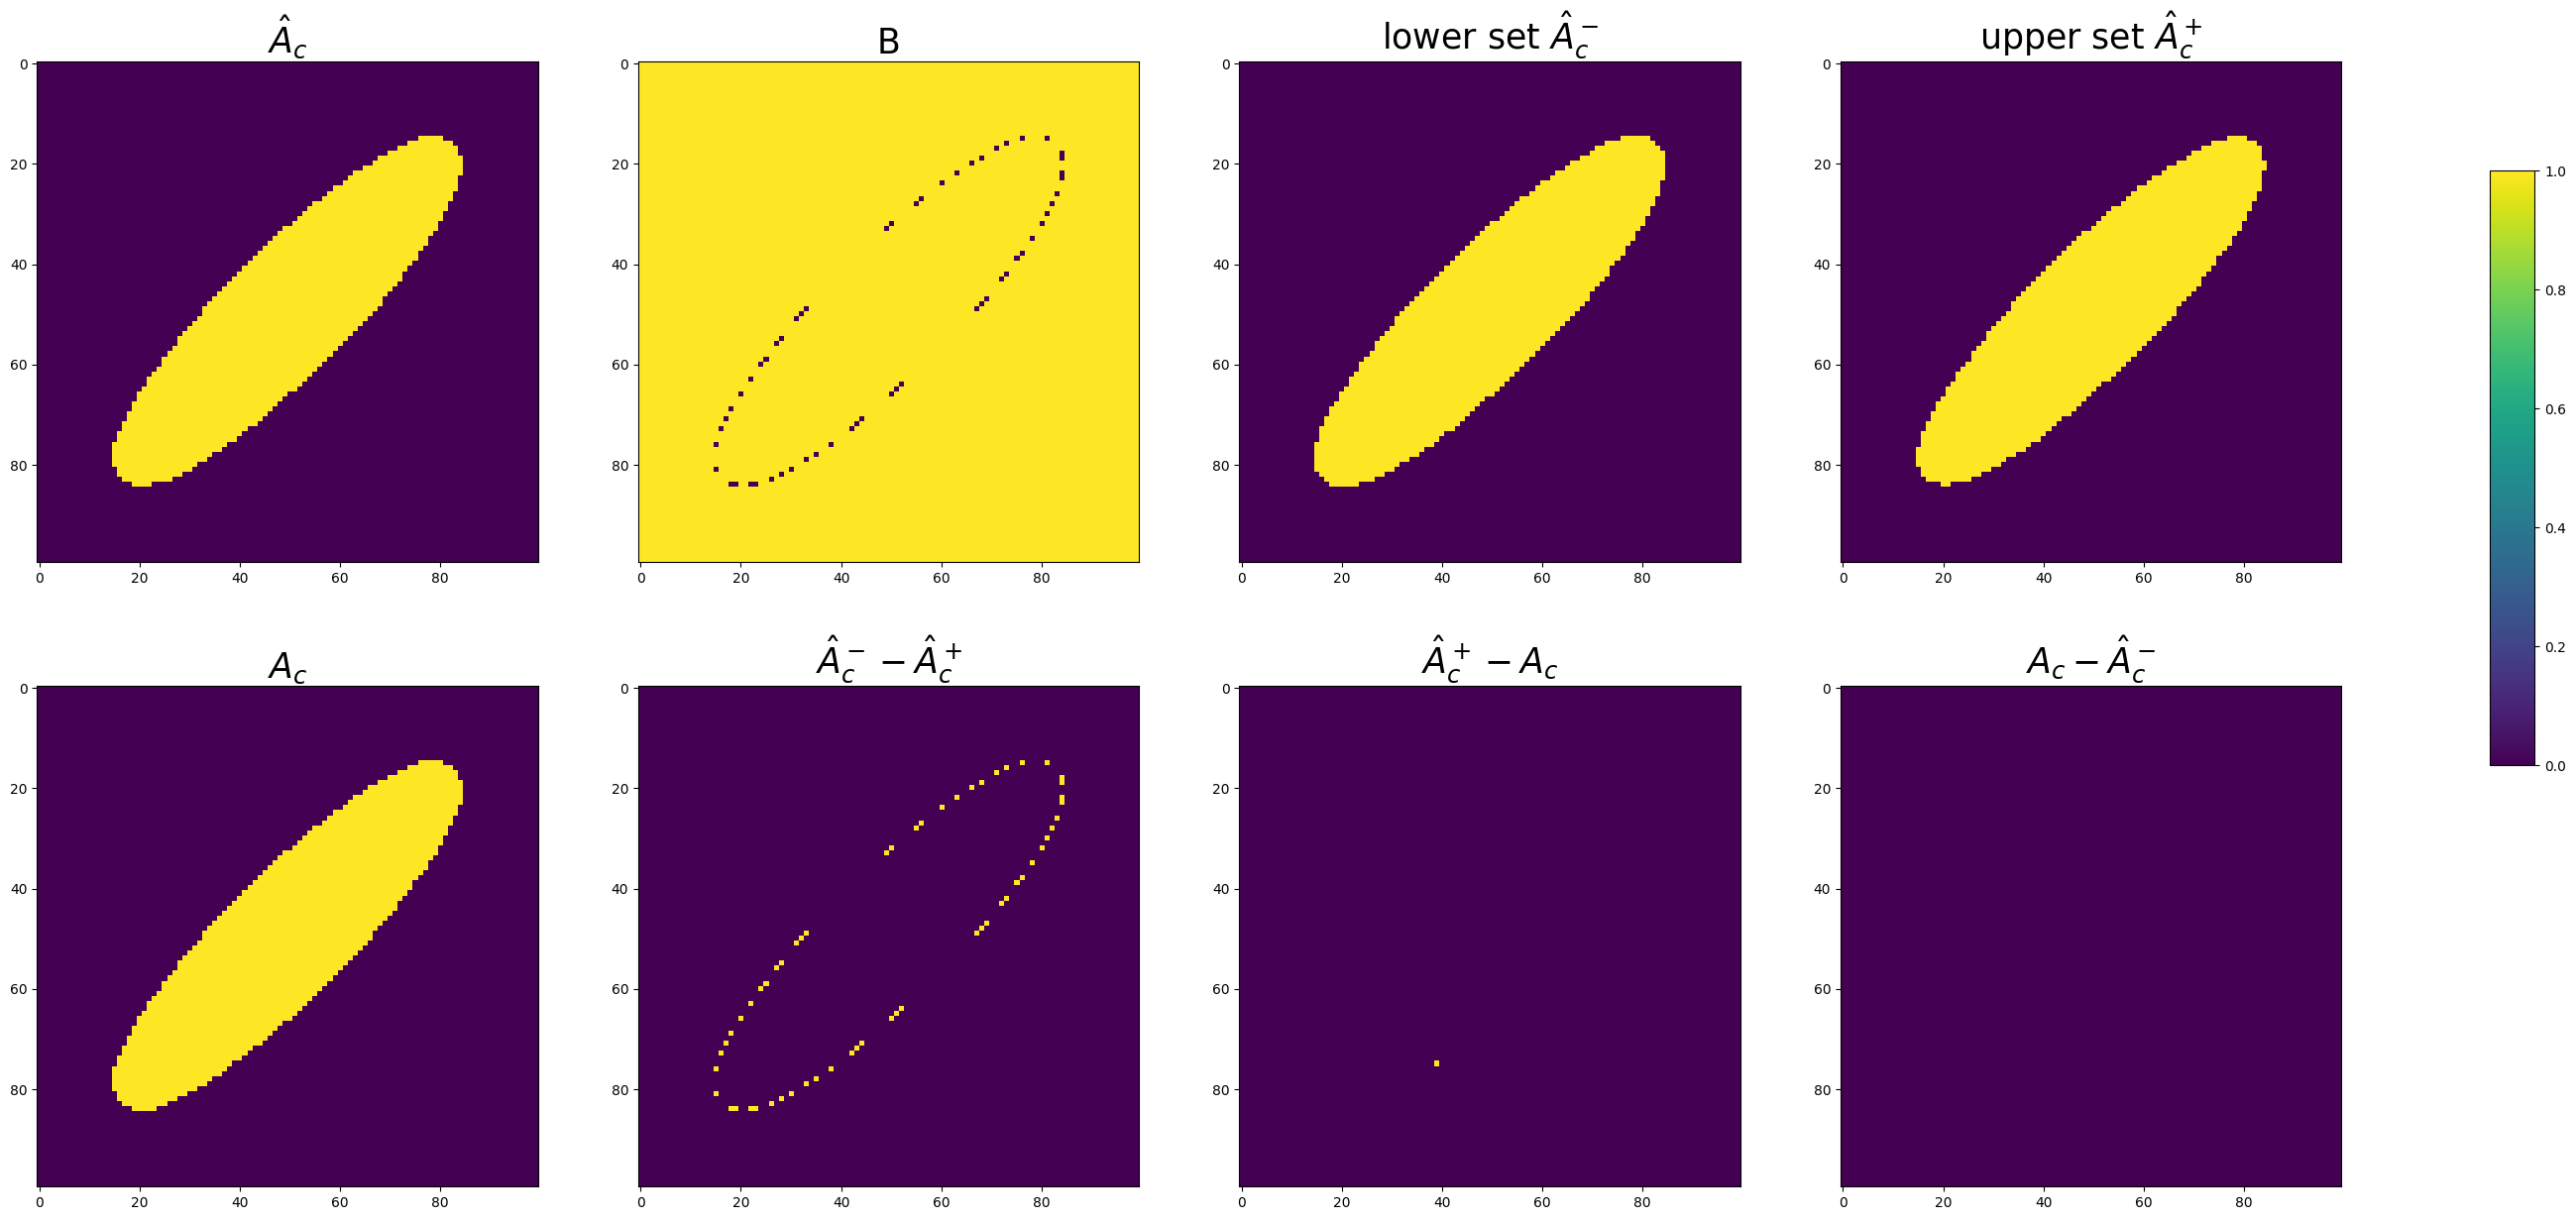

In [ ]:
#option 1

threshold = 2
alpha = 0.05


data = ellipse_100_smth
mu = mu_ellipse_100
Ac = mu >= threshold


data_tstat = mvtstat(data - threshold)
data_dim = data.shape
nsubj = data_dim[0]
Achat = data_tstat >= 0
Achat_C = data_tstat < 0



inner_pvals = 1 - scipy.stats.t.cdf(data_tstat, df=nsubj - 1)
outer_pvals = scipy.stats.t.cdf(data_tstat, df=nsubj - 1)
min_pvals = np.minimum(inner_pvals, outer_pvals)

rejection_ind, _, n_rej = fdr_BH(min_pvals, alpha)

outer_set = 1 - Achat_C * rejection_ind
inner_set = Achat * rejection_ind

outsubinn = np.maximum(outer_set - inner_set, 0)
FN_upp = np.maximum(inner_set - Ac, 0)
FN_low = np.maximum(Ac-outer_set, 0)


fig, axs = plt.subplots(2, 4, figsize=(30, 15))

_min, _max = 0,1

im = axs[0,0].imshow(Achat, vmin = _min, vmax = _max)
axs[0,0].set_title("$\hat{A}_c$", fontsize = 25)
im = axs[0,1].imshow(rejection_ind, vmin = _min, vmax = _max)
axs[0,1].set_title("B", fontsize = 25)
im = axs[0,2].imshow(outer_set, vmin = _min, vmax = _max)
axs[0,2].set_title("lower set $\hat{A}_c^-$", fontsize = 25)
im = axs[0,3].imshow(inner_set, vmin = _min, vmax = _max)
axs[0,3].set_title("upper set $\hat{A}_c^+$", fontsize = 25)
im = axs[1,0].imshow(Ac, vmin = _min, vmax = _max)
axs[1,0].set_title("$A_c$", fontsize = 25)
im = axs[1,1].imshow(outsubinn)
axs[1,1].set_title("$\hat{A}_c^- - \hat{A}_c^+$", fontsize = 25)

im = axs[1,2].imshow(FN_upp, vmin = _min, vmax = _max)
axs[1,2].set_title("$\hat{A}_c^+ - A_c$", fontsize = 25)
im = axs[1,3].imshow(FN_low, vmin = _min, vmax = _max)
axs[1,3].set_title("$A_c - \hat{A}_c^- $", fontsize = 25)



cbar_ax = fig.add_axes([0.95, 0.4, 0.015, 0.4])
fig.colorbar(im, cax=cbar_ax, cmap='RdPu')
plt.show()


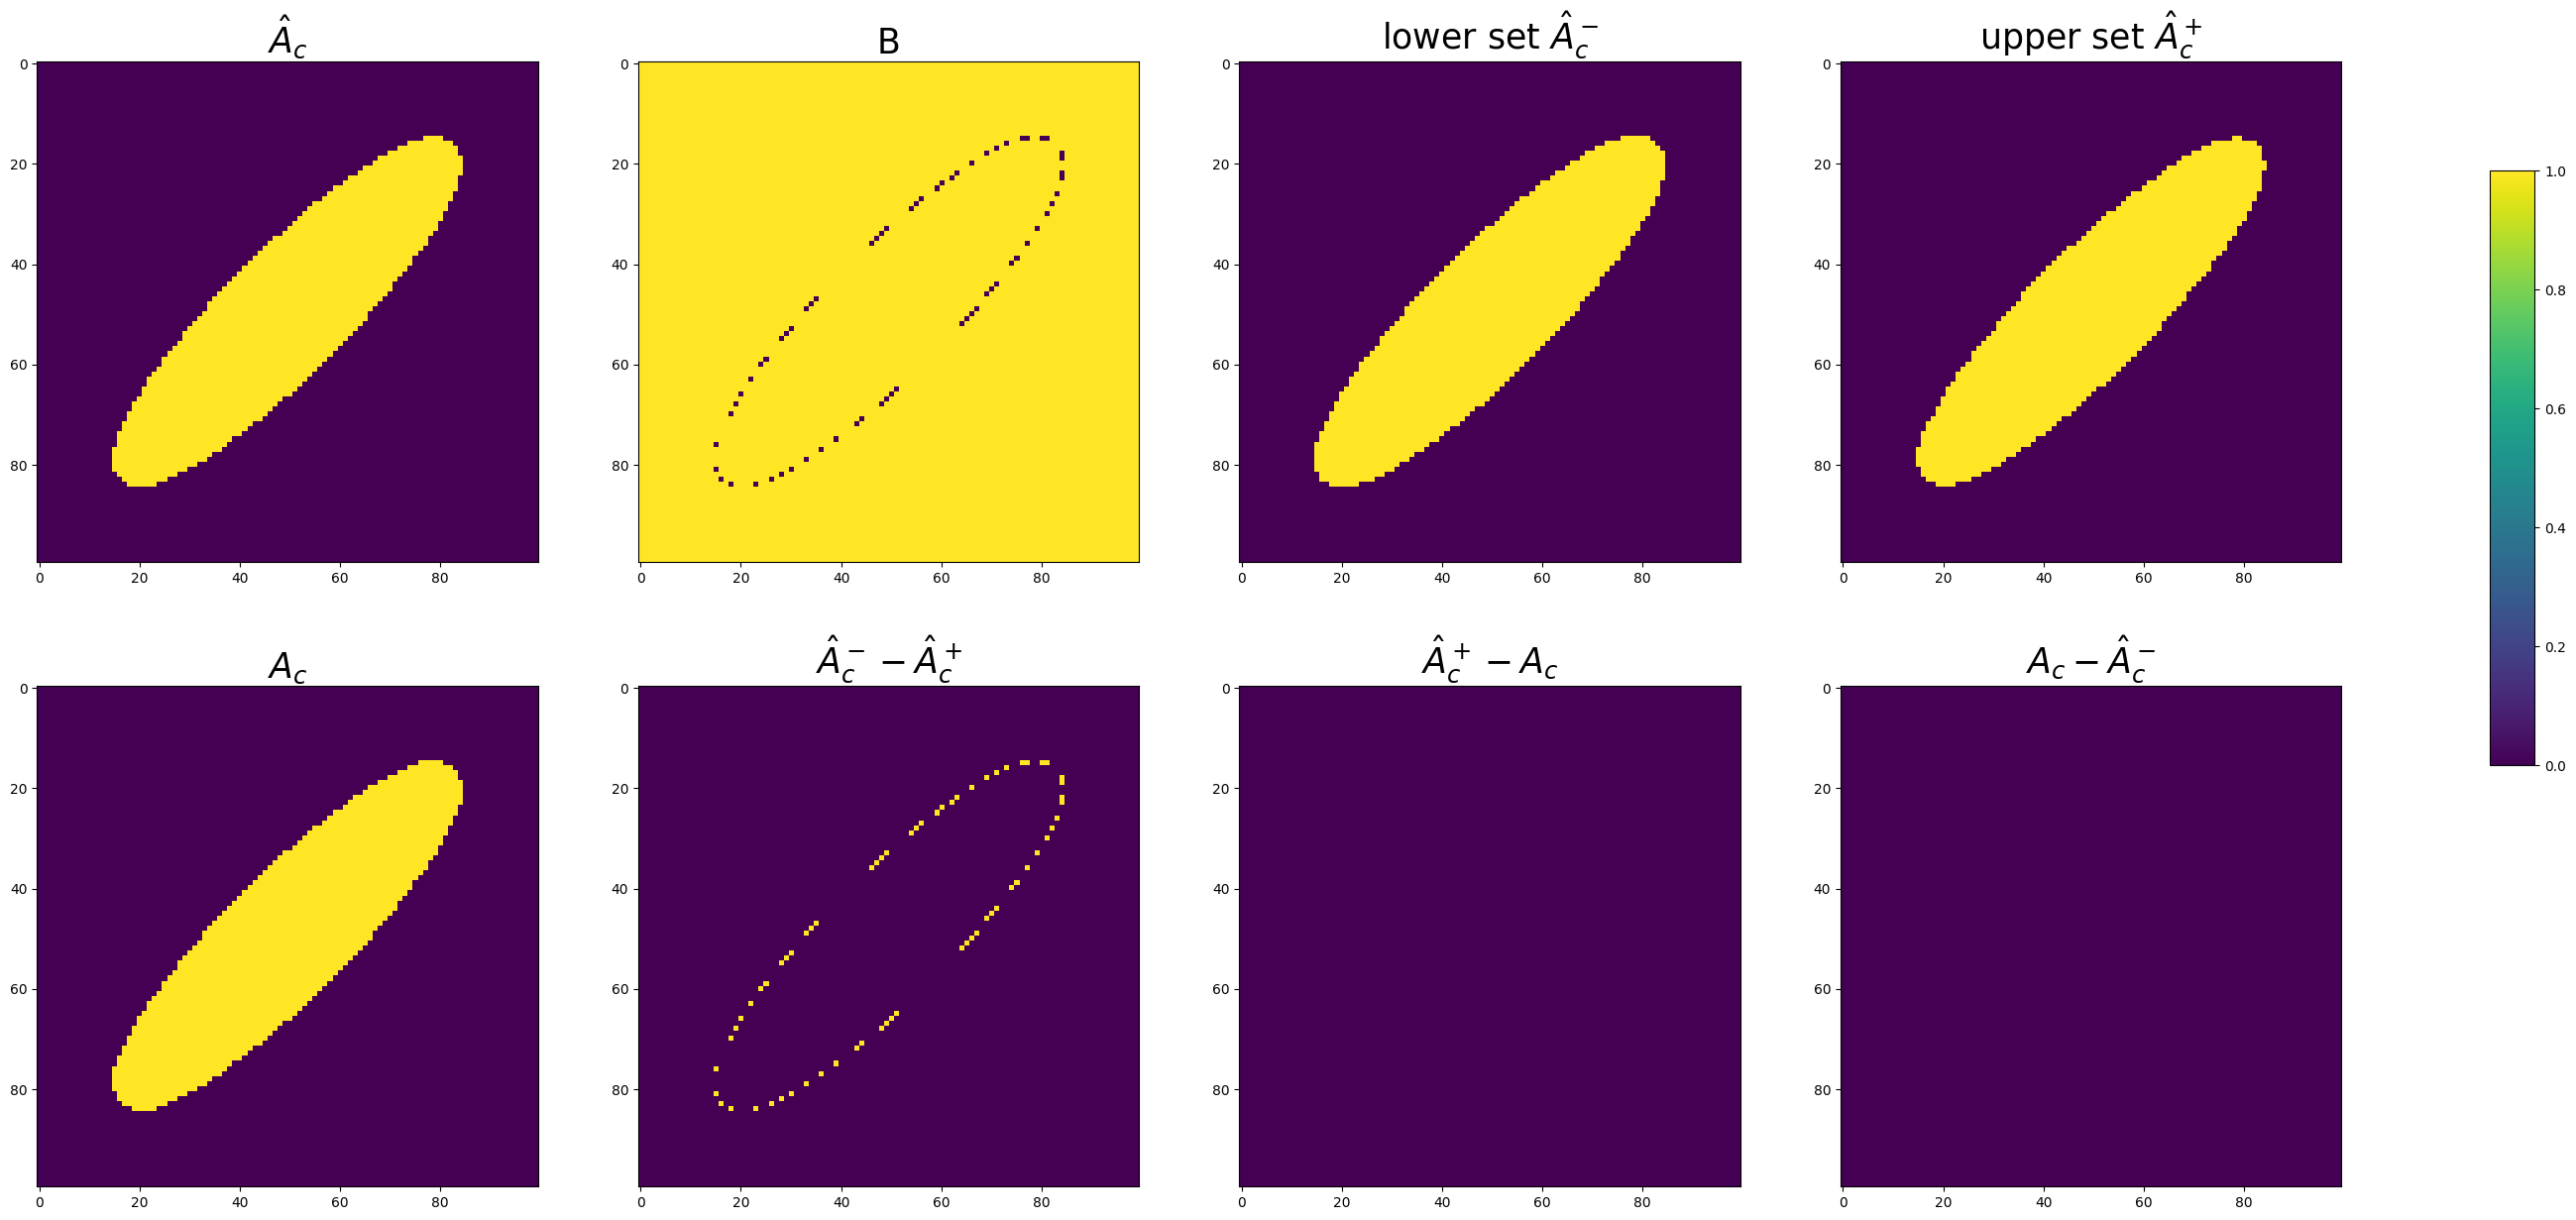

In [ ]:
#option 2
threshold = 2
alpha = 0.025


data = ellipse_100_smth
mu = mu_ellipse_100
Ac = mu >= threshold


data_tstat = mvtstat(data - threshold)
data_dim = data.shape
nsubj = data_dim[0]
Achat = data_tstat >= 0
Achat_C = data_tstat < 0
inner_pvals = 1 - scipy.stats.t.cdf(data_tstat, df=nsubj - 1)
outer_pvals = scipy.stats.t.cdf(data_tstat, df=nsubj - 1)
min_pvals = np.minimum(inner_pvals, outer_pvals)

rejection_ind, _, n_rej = fdr_BH(min_pvals, alpha)

outer_set = 1 - Achat_C * rejection_ind
inner_set = Achat * rejection_ind

outsubinn = np.maximum(outer_set - inner_set, 0)
FN_upp = np.maximum(inner_set - Ac, 0)
FN_low = np.maximum(Ac-outer_set, 0)


fig, axs = plt.subplots(2, 4, figsize=(30, 15))

_min, _max = 0,1

im = axs[0,0].imshow(Achat, vmin = _min, vmax = _max)
axs[0,0].set_title("$\hat{A}_c$", fontsize = 25)
im = axs[0,1].imshow(rejection_ind, vmin = _min, vmax = _max)
axs[0,1].set_title("B", fontsize = 25)
im = axs[0,2].imshow(outer_set, vmin = _min, vmax = _max)
axs[0,2].set_title("lower set $\hat{A}_c^-$", fontsize = 25)
im = axs[0,3].imshow(inner_set, vmin = _min, vmax = _max)
axs[0,3].set_title("upper set $\hat{A}_c^+$", fontsize = 25)
im = axs[1,0].imshow(Ac, vmin = _min, vmax = _max)
axs[1,0].set_title("$A_c$", fontsize = 25)
im = axs[1,1].imshow(outsubinn)
axs[1,1].set_title("$\hat{A}_c^- - \hat{A}_c^+$", fontsize = 25)

im = axs[1,2].imshow(FN_upp, vmin = _min, vmax = _max)
axs[1,2].set_title("$\hat{A}_c^+ - A_c$", fontsize = 25)
im = axs[1,3].imshow(FN_low, vmin = _min, vmax = _max)
axs[1,3].set_title("$A_c - \hat{A}_c^- $", fontsize = 25)



cbar_ax = fig.add_axes([0.95, 0.4, 0.015, 0.4])
fig.colorbar(im, cax=cbar_ax, cmap='RdPu')
plt.show()






## Confidence Sets
Now we look at $\hat{A}_c^+ + \hat{A}_c^-$ + $A_c$

### Joint and Separate Error Control
 Used k=2, $\alpha_0 = 0.05/4$, $\alpha_1 = 0.05/2$

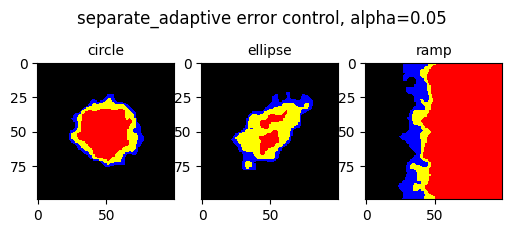

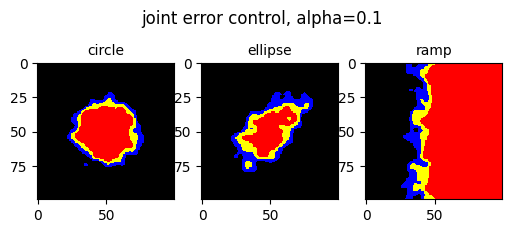

In [24]:
fn = 6
fs = 40
figsize = (6,2.5)
mag=5
std = 1.5
conf_plot_agg(threshold=2, method="separate_adaptive", seed=1004, std=std, mag=mag, fwhm_noise=fn, fwhm_signal=fs,  fontsize=10, alpha=0.05, figsize = figsize)
conf_plot_agg(threshold=2, method="joint", seed=1004, std=std, mag=mag, fwhm_noise=fn, fwhm_signal=fs,  fontsize=10, alpha=0.1, figsize = figsize)


# FDR Simulations

## simulation signals

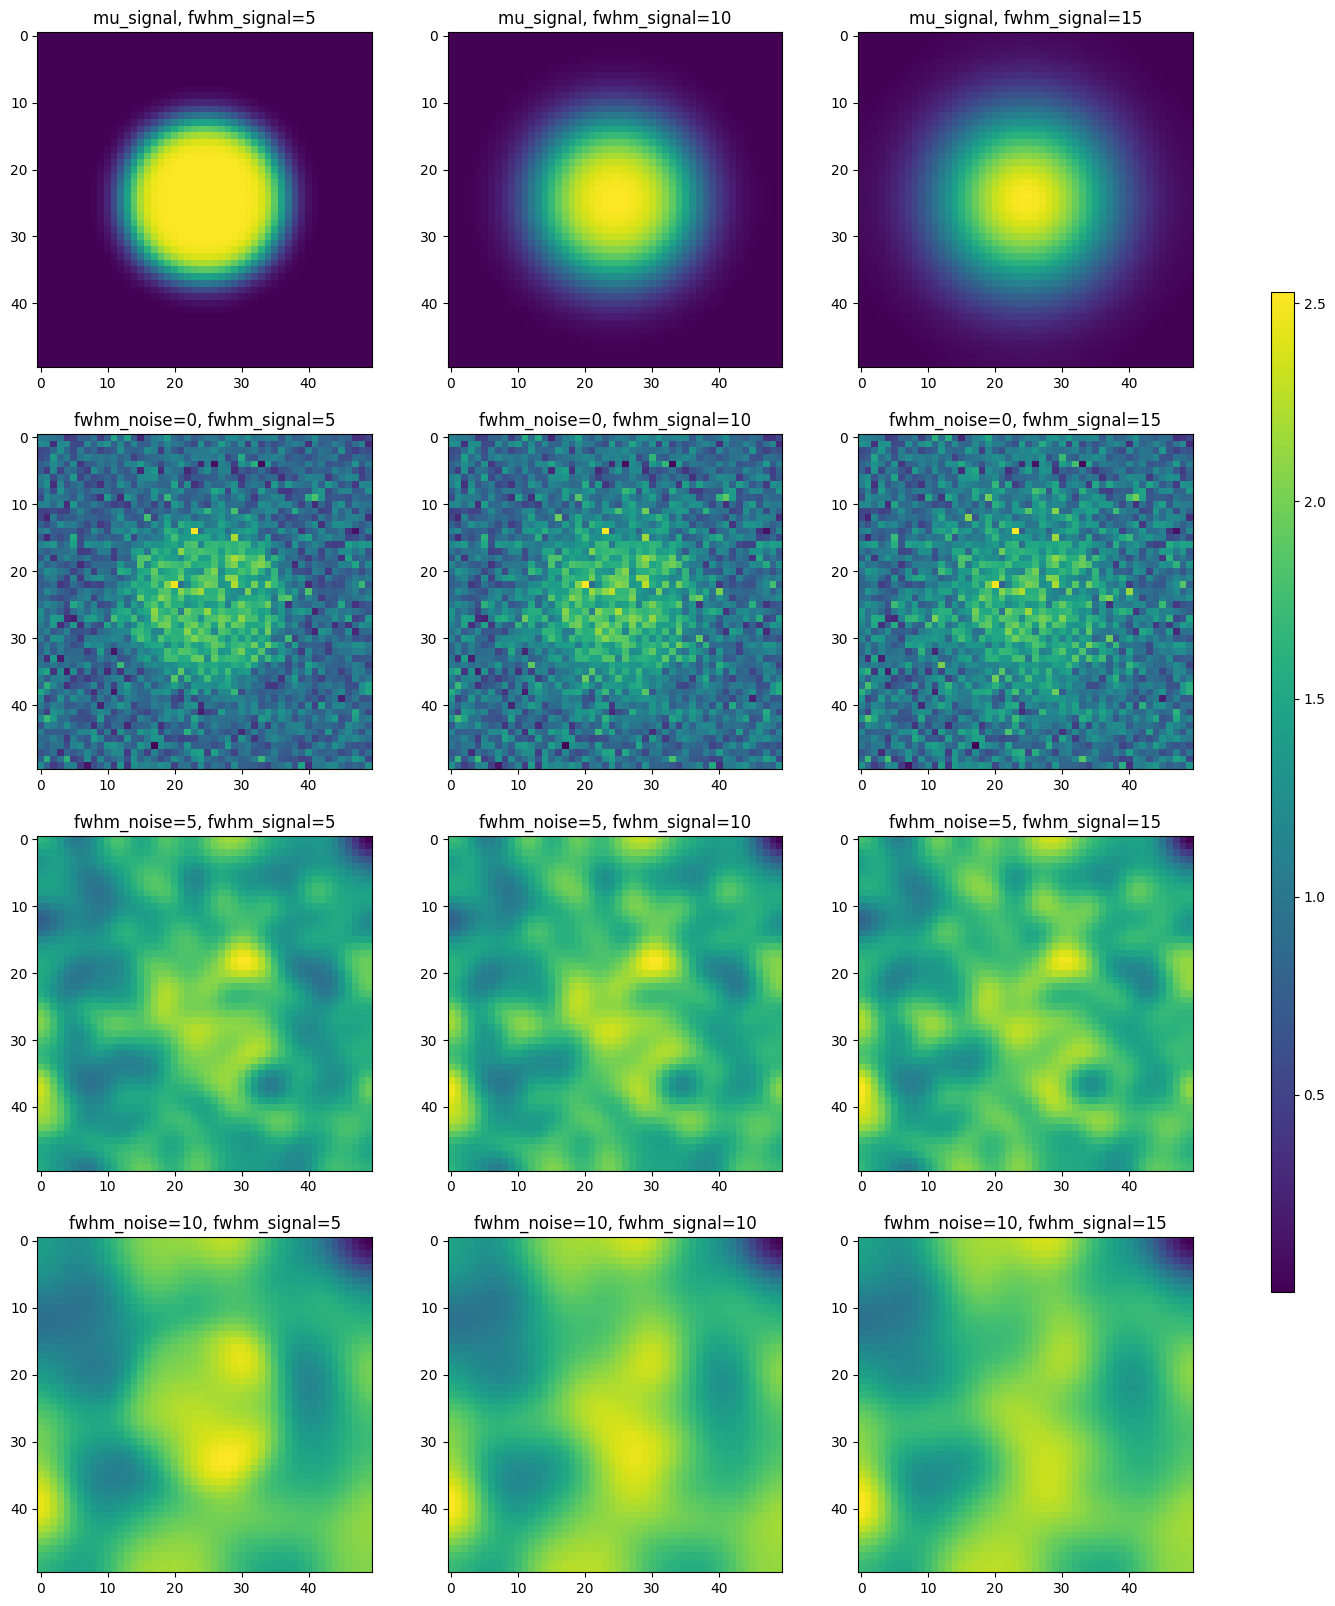

In [27]:
fwhm_signal_vec = [5, 10, 15]
fwhm_noise_vec = [0, 5, 10]

shape_spec_circle = {'r':0.5, 'mag':3,
                  'fwhm_signal': 0,
                  'fwhm_noise': 0,
                  'std': 1 }

shape_spec_step = {
    'fwhm_signal': 0,
    'fwhm_noise': 0,
    'std': 1}

shape_spec_ramp = {'direction': 1,
                  'mag':(-1,1),
                  'fwhm_noise': 0,
               'std': 1}
get_sim_signal(shape="circle", shape_spec=shape_spec_circle, fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec)

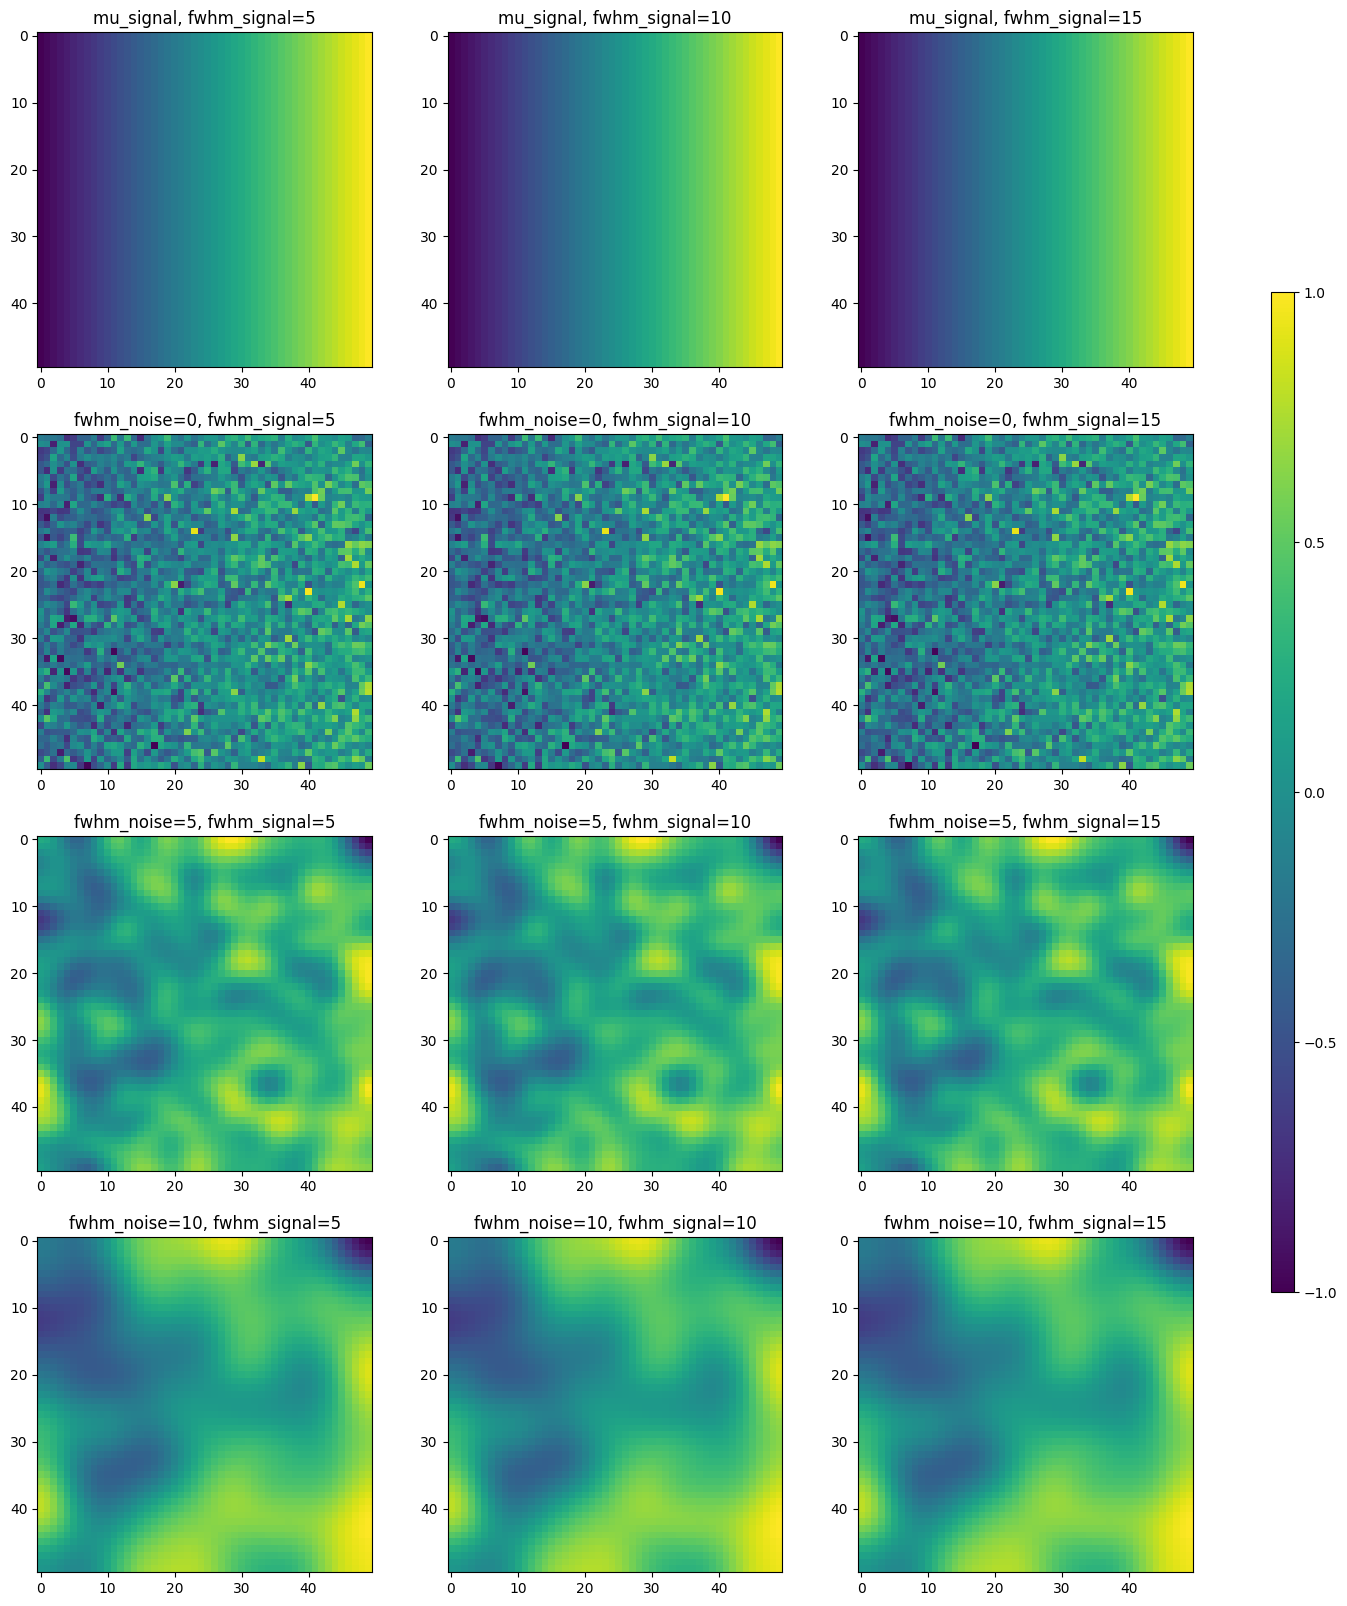

In [28]:
get_sim_signal(shape="ramp", shape_spec=shape_spec_ramp, fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec)

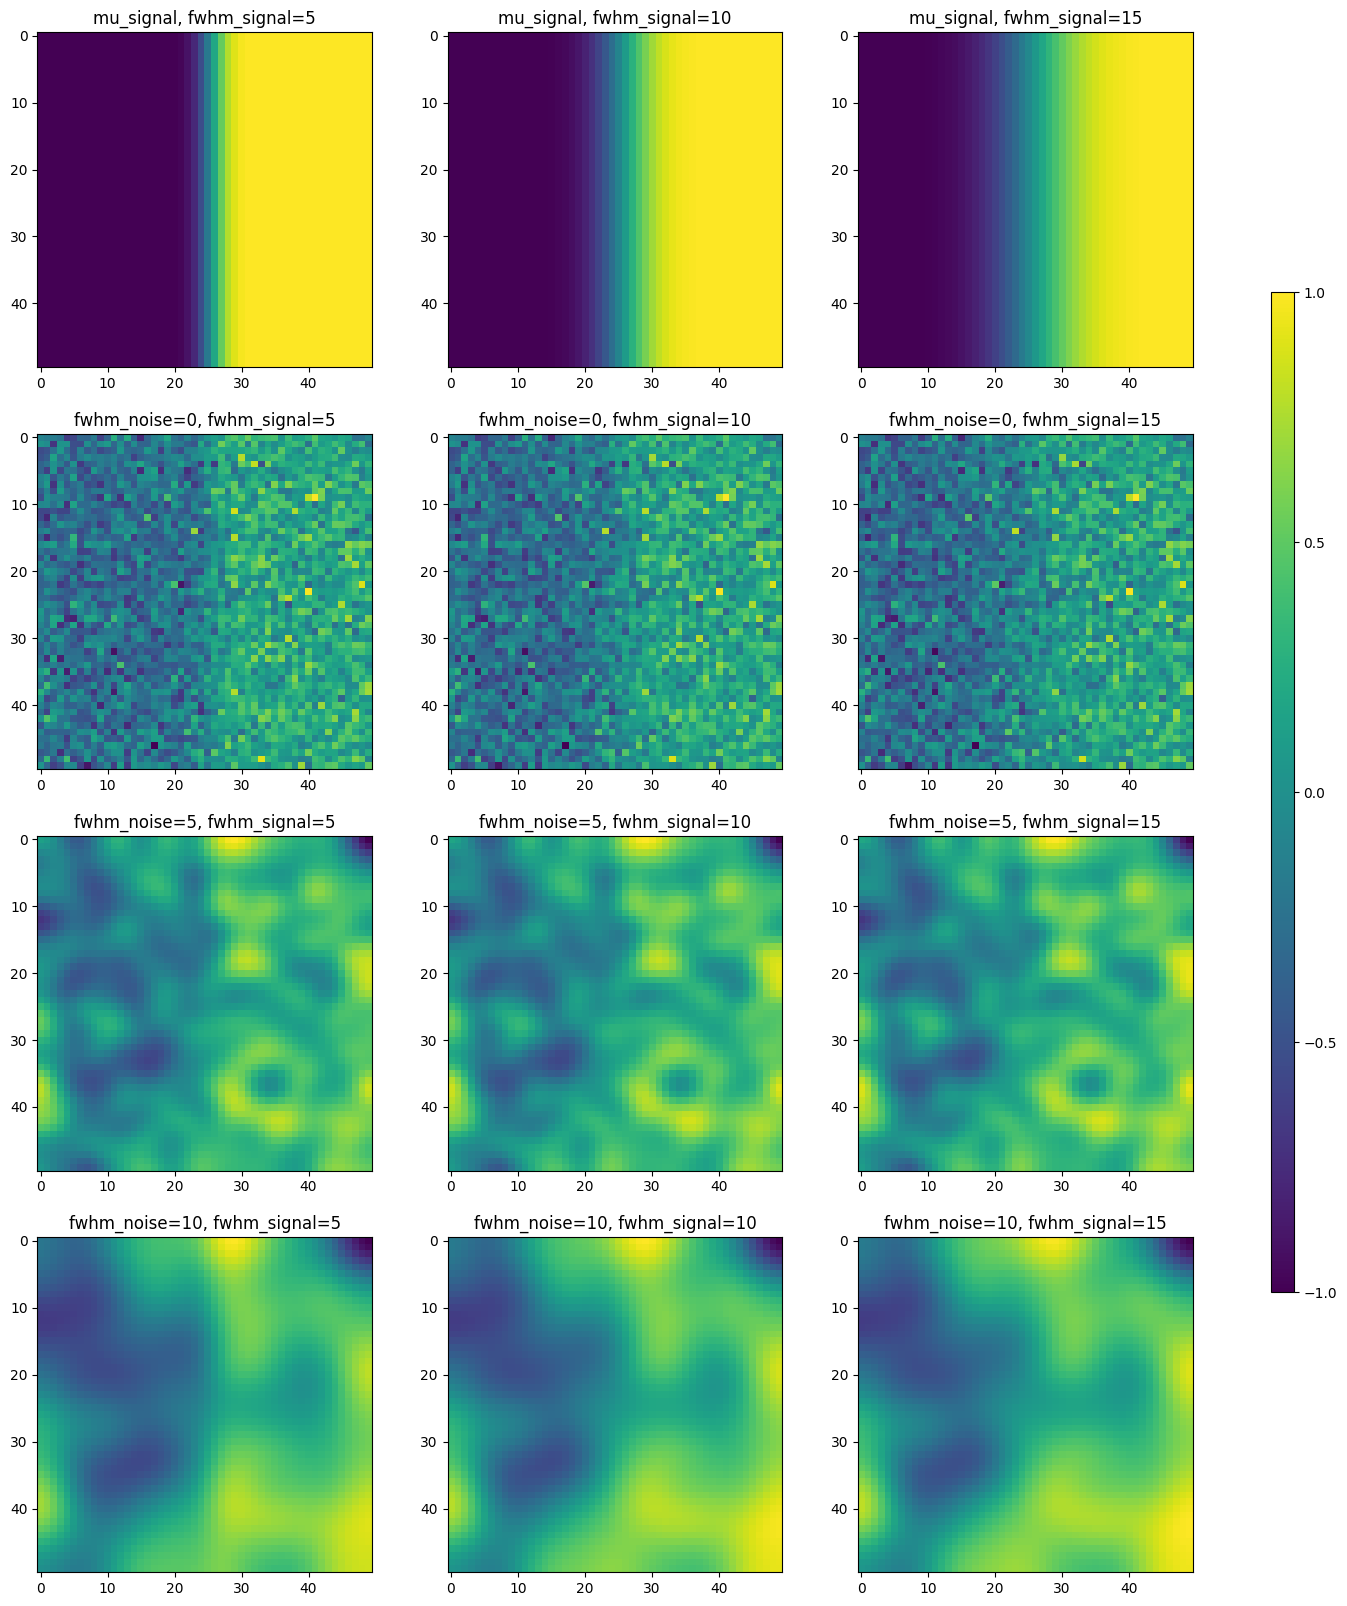

In [29]:
get_sim_signal(shape="step", shape_spec=shape_spec_step, fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec)

## threshold simulation

In [35]:
fwhm_signal_vec = [5, 10, 15]
fwhm_noise_vec = [0, 5, 10]
sim_num = 1
figsize = (15, 20)
std = 1

/Users/howonryu/Projects/ConfidenceSet/ConfidenceSet/confidenceset/confset.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  y = (2 * kinv) / (1 - np.sqrt(1 - 4 * (1 - x) * kinv))


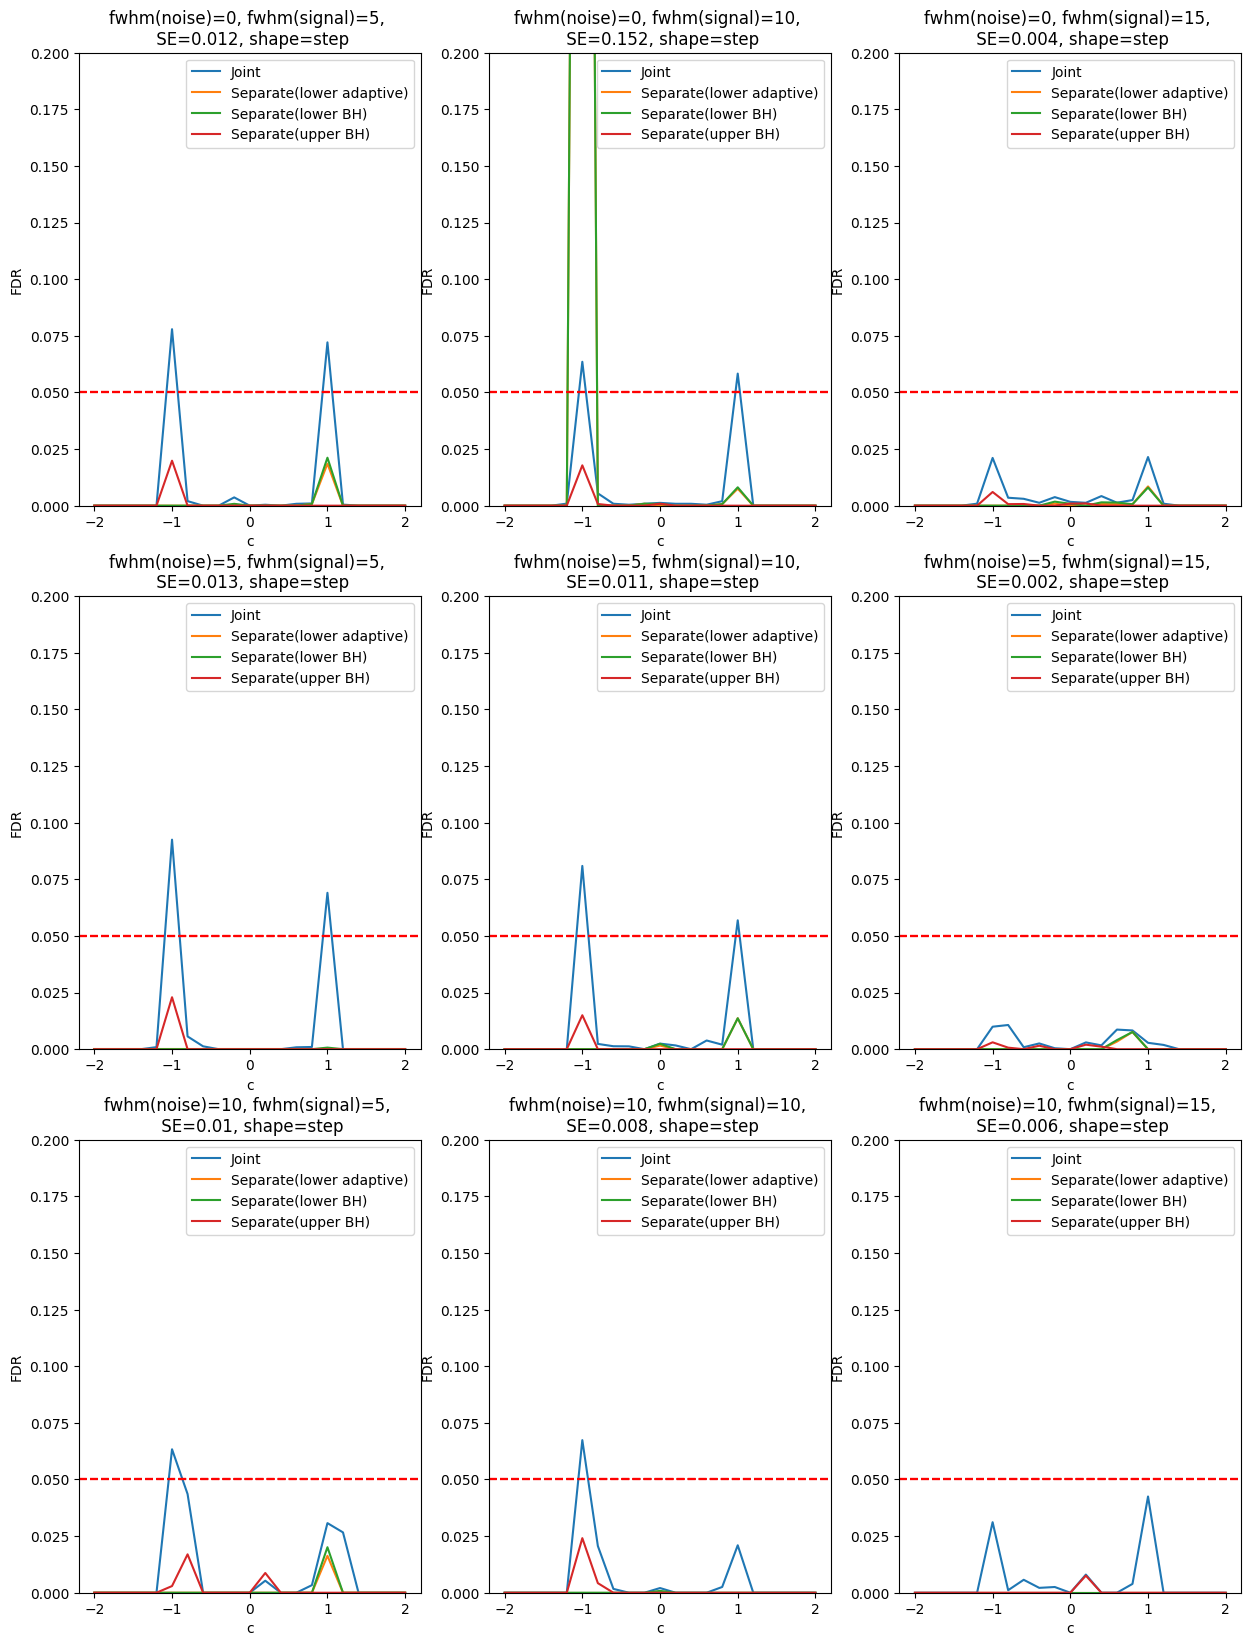

In [36]:
FDR_step = sim_threshold(sim_num=sim_num, c=np.linspace(-2, 2, num=21), mode="FDR", shape="step",
                   fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec, std=std,
                        alpha=0.05,  figsize=figsize)
with open('FDR_step.pkl', 'wb') as pickle_file:
    pickle.dump(FDR_step, pickle_file)


/usr/local/lib/python3.10/dist-packages/confidenceset/confset.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  y = (2 * kinv) / (1 - np.sqrt(1 - 4 * (1 - x) * kinv))


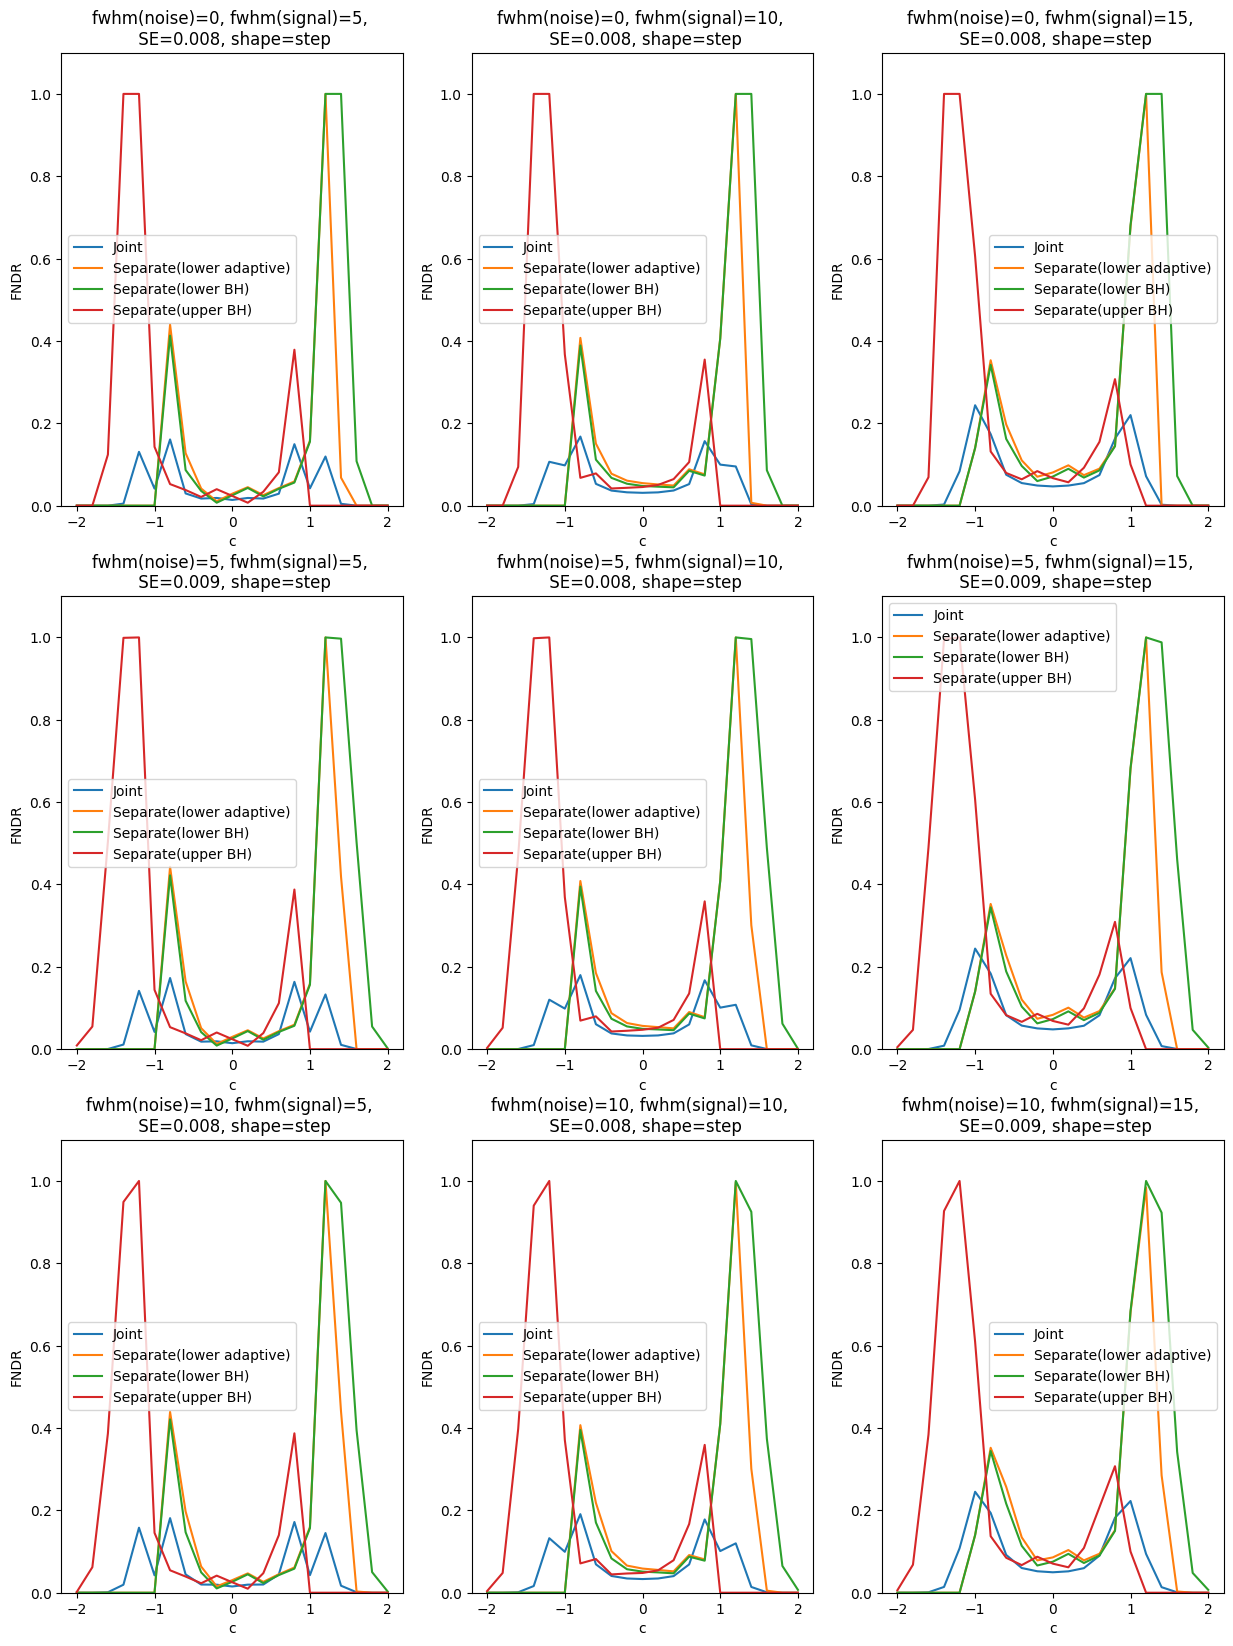

In [ ]:
FNDR_step = sim_threshold(sim_num=sim_num, c=np.linspace(-2, 2, num=21), mode="FNDR", shape="step",
                   fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec, std=std,
                       c_marg=0.2,  alpha=0.05, alpha0=0.05/4, alpha1=0.05/2, figsize=figsize)
with open('FNDR_step.pkl', 'wb') as pickle_file:
    pickle.dump(FNDR_step, pickle_file)

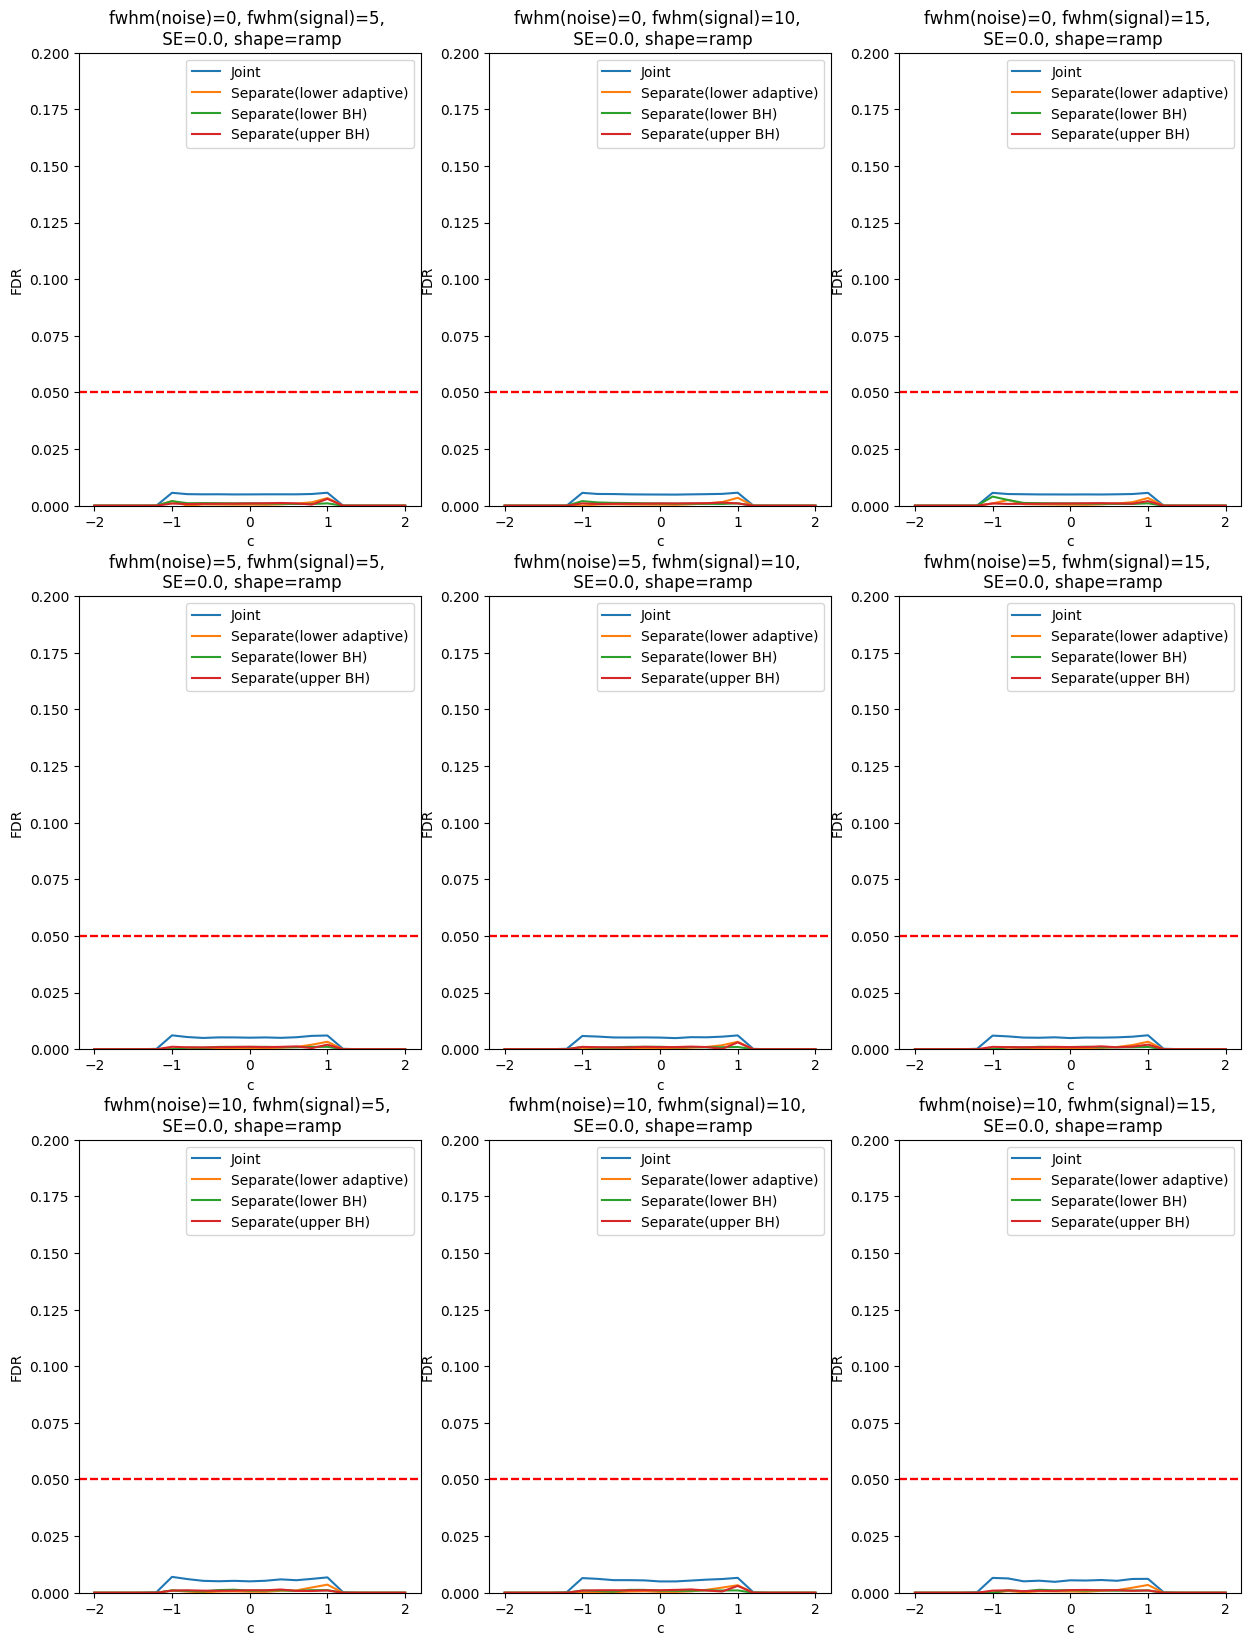

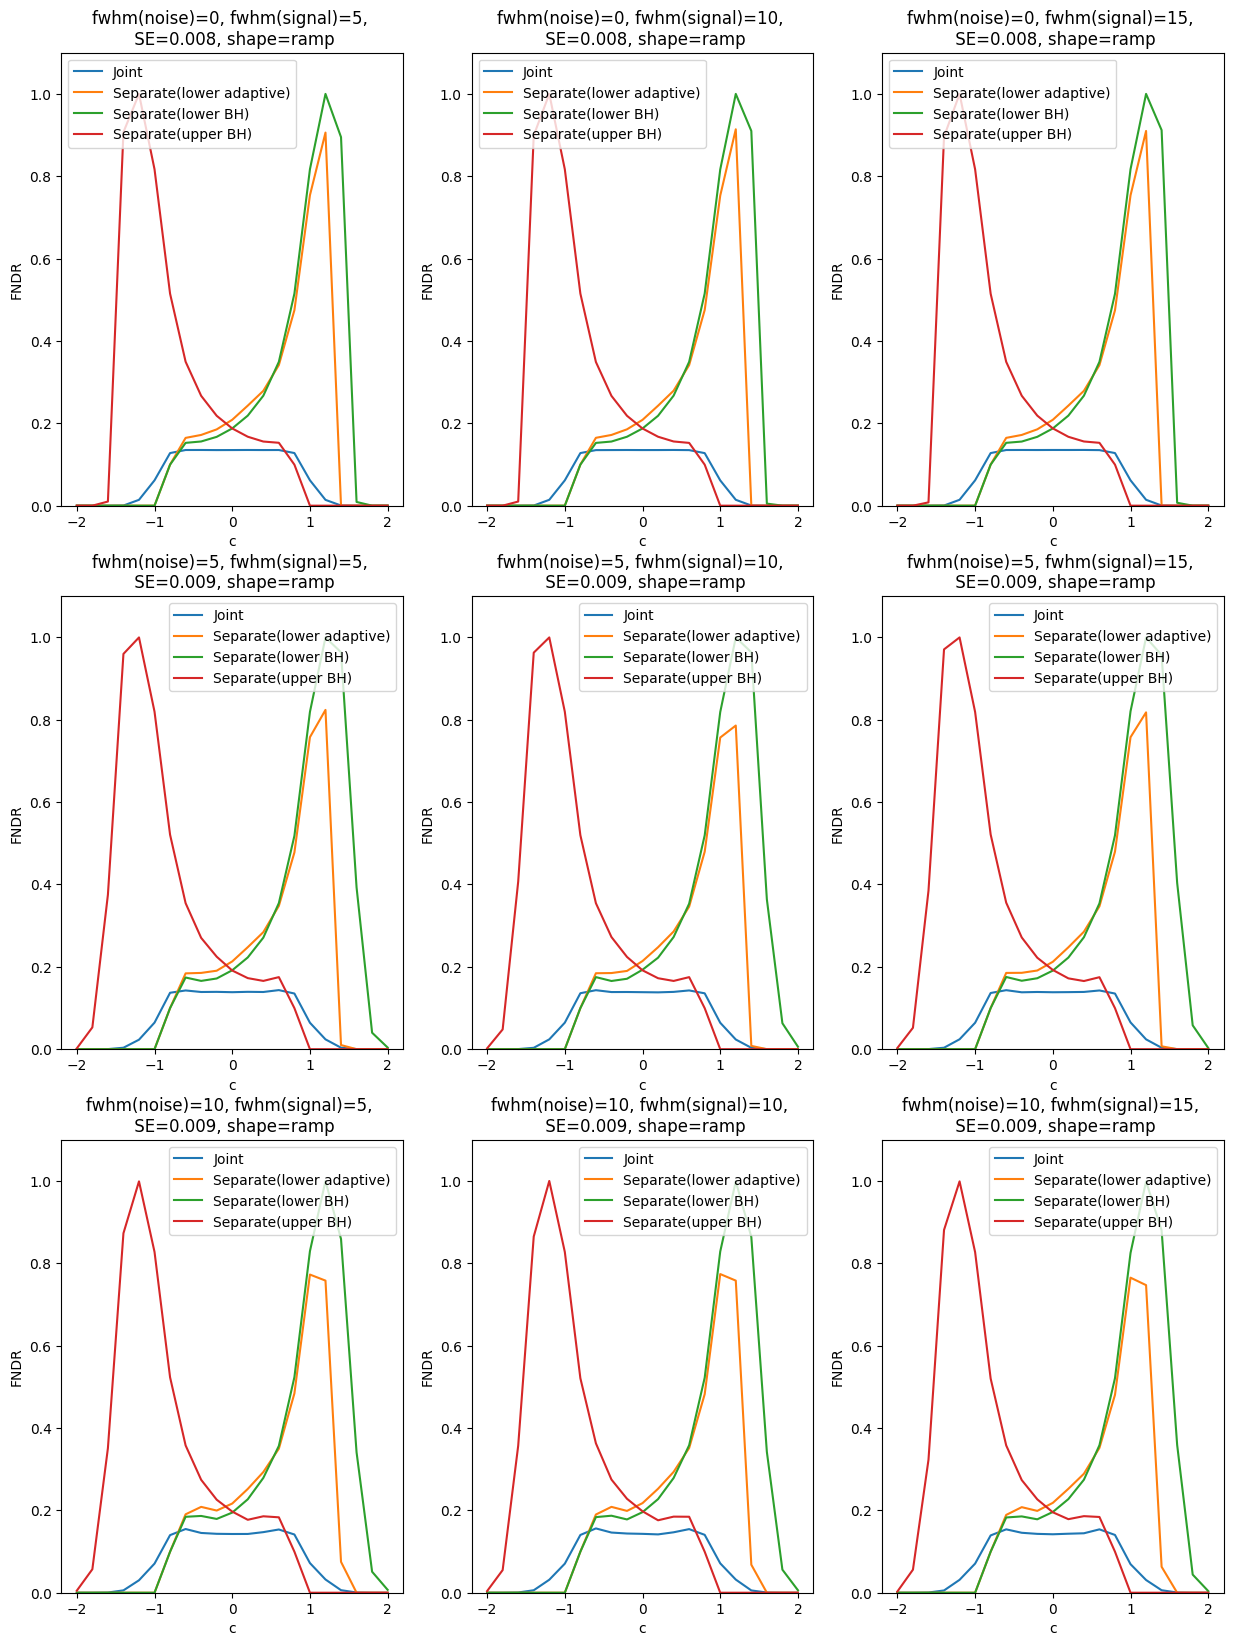

In [ ]:
FDR_ramp = sim_threshold(sim_num=sim_num, c=np.linspace(-2, 2, num=21), mode="FDR", shape="ramp",
                   fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec, std=std,
                       c_marg=0.2,  alpha=0.05, alpha0=0.05/4, alpha1=0.05/2, figsize=figsize)
with open('FDR_ramp.pkl', 'wb') as pickle_file:
    pickle.dump(FDR_ramp, pickle_file)


FNDR_ramp = sim_threshold(sim_num=sim_num, c=np.linspace(-2, 2, num=21), mode="FNDR", shape="ramp",
                   fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec, std=std,
                       c_marg=0.2, alpha=0.05, alpha0=0.05/4, alpha1=0.05/2, figsize=figsize)
with open('FNDR_ramp.pkl', 'wb') as pickle_file:
    pickle.dump(FNDR_ramp, pickle_file)

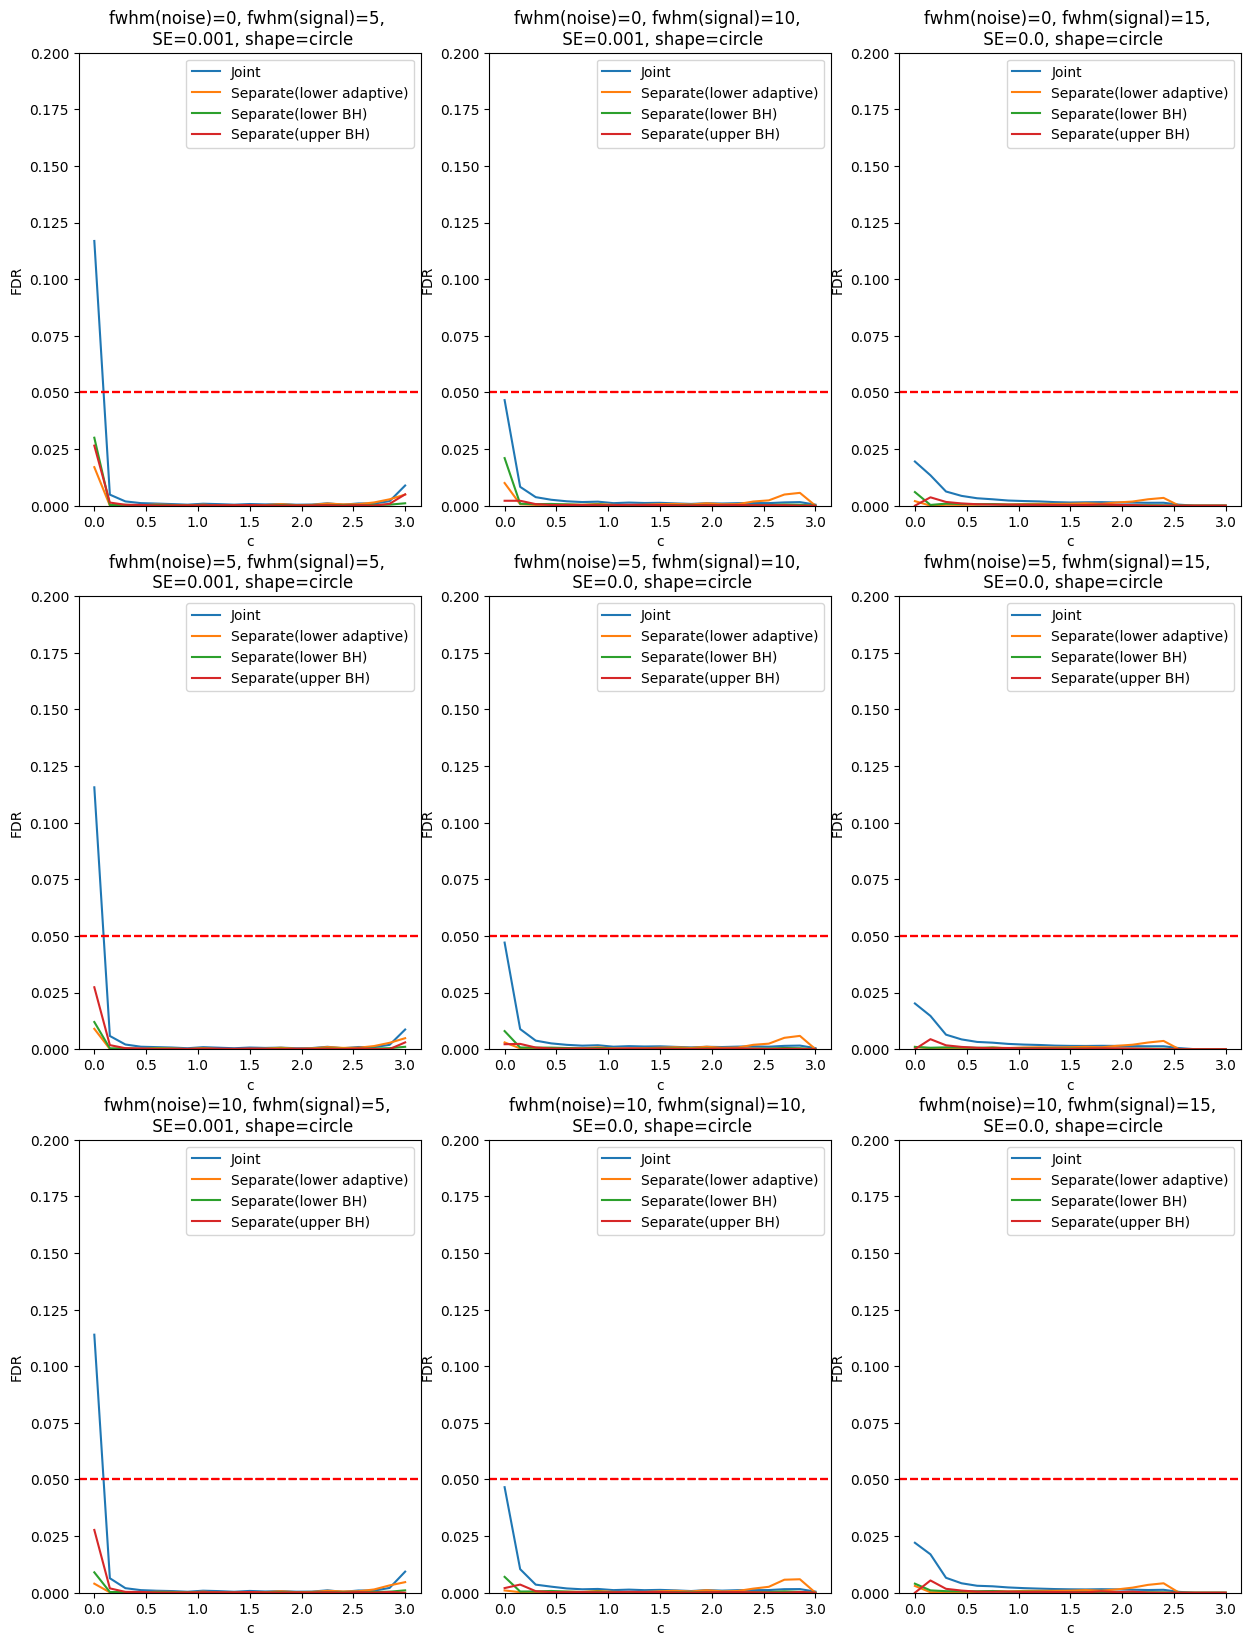

In [ ]:
FDR_circle = sim_threshold(sim_num=sim_num, c=np.linspace(0, 3, num=21), mode="FDR", shape="circle",
                   fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec, std=std,
                       c_marg=0.2,  alpha=0.05, alpha0=0.05/4, alpha1=0.05/2, figsize=figsize)
with open('FDR_circle.pkl', 'wb') as pickle_file:
    pickle.dump(FDR_circle, pickle_file)



/usr/local/lib/python3.10/dist-packages/confidenceset/confset.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  y = (2 * kinv) / (1 - np.sqrt(1 - 4 * (1 - x) * kinv))


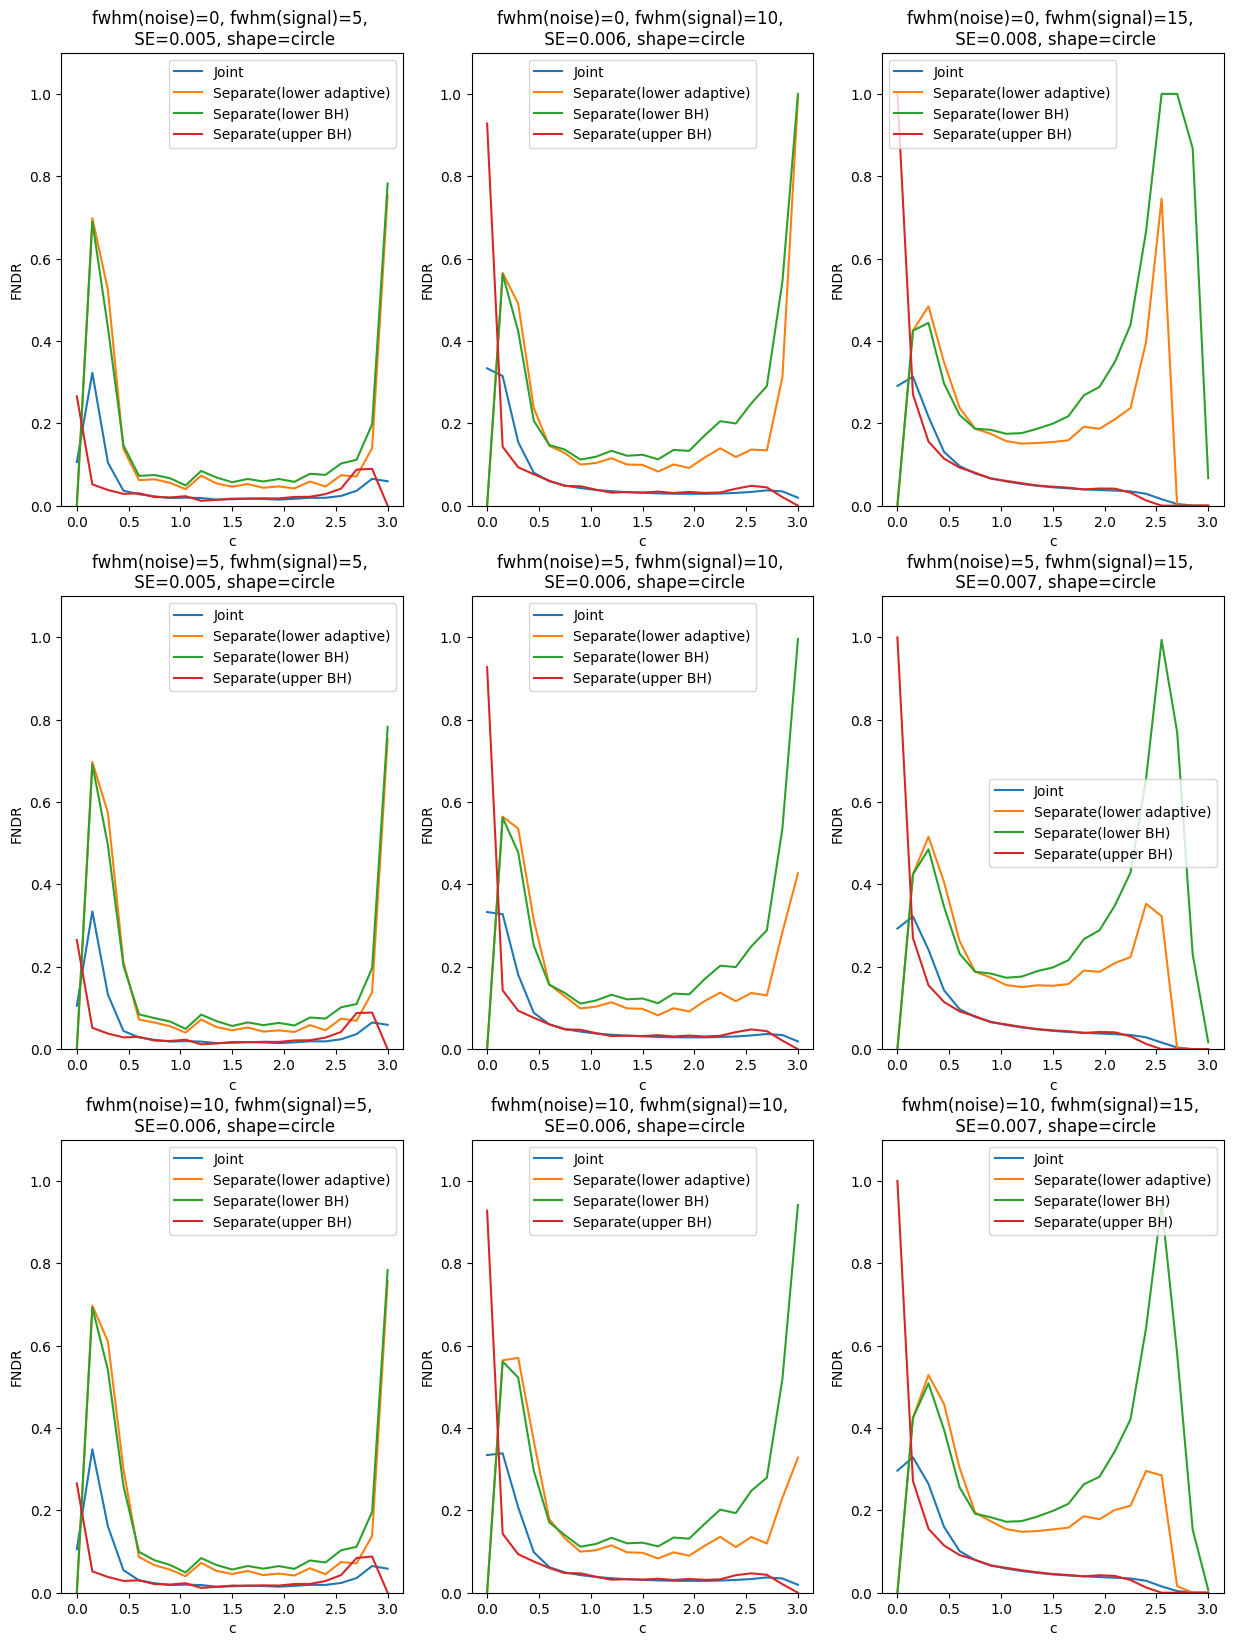

In [ ]:
FNDR_circle = sim_threshold(sim_num=sim_num, c=np.linspace(0, 3, num=21), mode="FNDR", shape="circle",
                   fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec, std=std,
                       c_marg=0.2,  alpha=0.05, alpha0=0.05/4, alpha1=0.05/2, figsize=figsize)
with open('FNDR_circle.pkl', 'wb') as pickle_file:
    pickle.dump(FNDR_circle, pickle_file)

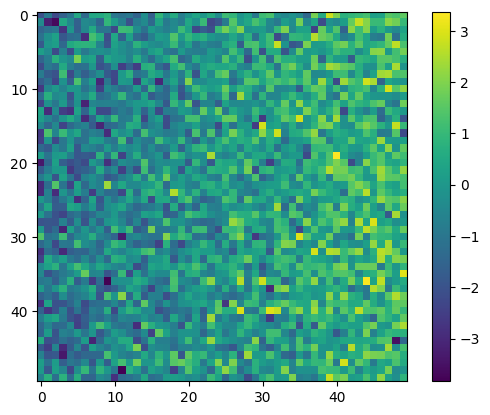

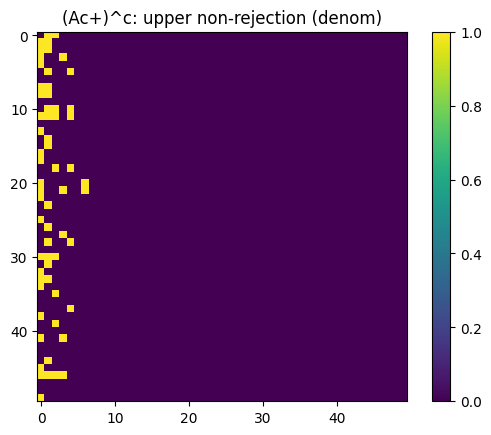

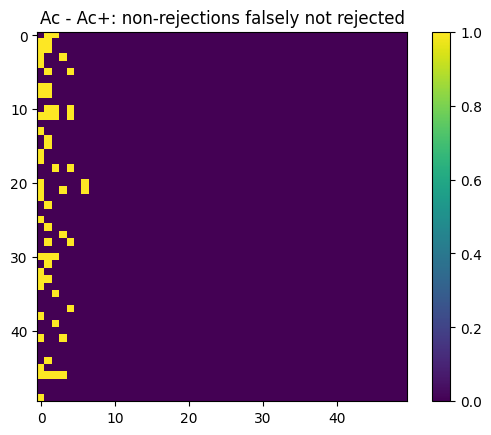

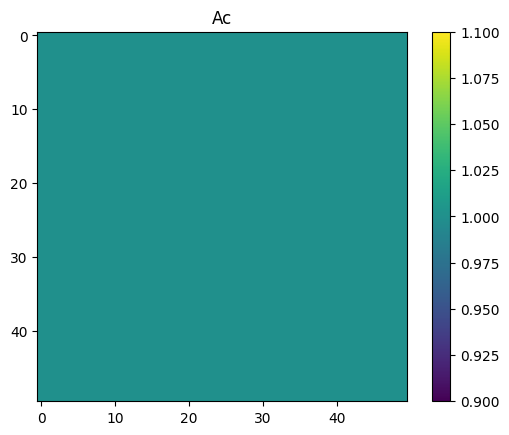

[0.0, 1.0]


In [ ]:
shape_spec_ramp = {'direction': 1,
                  'mag':(-1,1),
                  'fwhm_noise': 0,
               'std': 1}

th = -1.2
test_ramp, test_ramp_mu = gen_2D(dim=(80,50,50), shape="ramp", shape_spec=shape_spec_ramp)


plt.imshow(test_ramp[0,:,:])
plt.colorbar()
plt.show()


lower, upper, Achat, _, n_rej = fdr_confset(data=test_ramp, threshold=th, method="separate_BH", alpha=0.05)

plt.imshow(1-upper)
plt.title("(Ac+)^c: upper non-rejection (denom)")
plt.colorbar()
plt.show()

plt.imshow(np.maximum(Ac.astype(int) - upper, 0))
plt.title("Ac - Ac+: non-rejections falsely not rejected")
plt.colorbar()
plt.show()

plt.imshow(Ac.astype(int))
plt.title("Ac")
plt.colorbar()
plt.show()

Ac = test_ramp_mu > th
AcC = 1 - Ac
Acbar = test_ramp_mu >= th
AcbarC = 1-Acbar

dim = (80, 50, 50)
m = dim[1] * dim[2]
ERR = [None, None]

if n_rej[1] == m:
  ERR[1] = 0
  #print("all rejection (upper)")
else:
  upper_nom = np.sum(np.maximum(Ac.astype(int) - upper, 0))
  upper_denom = np.sum(1-upper)
  upper_ERR = upper_nom / upper_denom
  ERR[1] = upper_ERR
  #print(f'upper non rej={m-n_rej[1]}, upper_denom={upper_denom}')

if n_rej[0] == m:
  ERR[0] = 0
  #print("all rejection (lower)")
else:
  lower_nom = np.sum(np.maximum(lower - Acbar.astype(int), 0))
  lower_denom = np.sum(lower)
  lower_ERR = lower_nom / lower_denom
  ERR[0] = lower_ERR
  #print(f'lower non rej={m-n_rej[0]}, lower_denom={lower_denom}')

print(ERR)

## sample size simulation


In [ ]:
def sim_table_n(sim_num, mode, shape, shape_spec, threshold, n_vec,
                        c_marg=0.2, alpha=0.05):
    """
    produces table for FDR, and FNDR simulation result

    Parameters
    ----------
    sim_num : int
      simulation number
    mode : str
      options for error rate "FDR" or "FNDR"
    method : str
      "joint", "separate_adaptive" or "separate_BH"
    shape : str
      "ramp" or "ellipse"
    shape_spec : dict
      dictionary containing shape specs
    c : list
      list of thresholds
    dim : int
      dimension of the image (N, W, H)
    c_marg : int
      margin allowed for the threshold
    alpha : int
      [0, 1] alpha level

    Returns
    -------
    sim_table : array
      simulated error rate result

    Examples
    --------
    error_check_sim_table(sim_num=sim_num, mode=mode, method="joint",
                                      shape=shape, shape_spec=shape_spec, c=c,
                                      dim=dim, c_marg=0.2, alpha=0.05)

    :Authors:
      Howon Ryu <howonryu@ucsd.edu>
    """

    sim_table_adaptive_lower = np.empty([len(n_vec), sim_num])
    sim_table_BH_lower = np.empty([len(n_vec), sim_num])
    sim_table_BH_upper = np.empty([len(n_vec), sim_num])
    sim_table_joint = np.empty([len(n_vec), sim_num])
    dim = (0, 50, 50)

    for n_idx, n in enumerate(n_vec):
      temp_sim_table_adaptive_lower = list()
      temp_sim_table_BH_lower = list()
      temp_sim_table_BH_upper = list()
      temp_sim_table_joint = list()
      for i in np.arange(sim_num):
        seed = np.random.randint(0, 2**32 - 1)
        #print(f'seed:{seed}')
        dim = list(dim)
        dim[0] = n
        dim = tuple(dim)

        separate_adaptive_error_check = error_check(mode=mode, dim=dim, threshold=threshold, shape=shape,
                                          method="separate_adaptive", seed=seed, shape_spec=shape_spec, alpha=alpha)
        separate_BH_error_check = error_check(mode=mode, dim=dim, threshold=threshold, shape=shape,
                                          method="separate_BH", seed=seed, shape_spec=shape_spec, alpha=alpha)
        joint_error_check = error_check(mode=mode, dim=dim, threshold=threshold, shape=shape,
                                          method="joint", seed=seed, shape_spec=shape_spec, alpha=alpha*2)

        temp_sim_table_adaptive_lower.append(separate_adaptive_error_check[0])
        temp_sim_table_BH_lower.append(separate_BH_error_check[0])
        temp_sim_table_BH_upper.append(separate_BH_error_check[1])
        temp_sim_table_joint.append(joint_error_check)

      sim_table_adaptive_lower[n_idx, :] = temp_sim_table_adaptive_lower
      sim_table_BH_lower[n_idx, :] = temp_sim_table_BH_lower
      sim_table_BH_upper[n_idx, :] = temp_sim_table_BH_upper
      sim_table_joint[n_idx, :] = temp_sim_table_joint

    return sim_table_adaptive_lower, sim_table_BH_lower, sim_table_BH_upper, sim_table_joint




def sim_plot_single_n(sim_num, mode, shape, shape_spec, n_vec, dim, threshold, ax,
                            c_marg=0.2, alpha=0.05):
  """
  plots error rate simulation

  Parameters
  ----------
  sim_num : int
    simulation number
  mode : str
    options for error rate "FDR" or "FNDR"
  shape : str
    "ramp" or "ellipse"
  shape_spec : dict
    dictionary containing shape specs
  c : list
    list of thresholds
  dim : int
    dimension of the image (N, W, H)
  ax : axes
    subplot figure to use
  c_marg : int
    margin allowed for the threshold
  tail : str
    "one" or "two"
  alpha : int
    [0, 1] alpha level

  Examples
  --------
  shapes = ["circular", "ellipse", "ramp"]
  # 50*50
  shape_specs_50 = shape_spec[0]
  fig, axs = plt.subplots(len(shape_specs_50), 3, figsize=figsize)
  for i in range(len(shape_specs_50)):
      for j, shape in enumerate(shapes):
          ax = axs[i, j]
          error_check_plot_single(sim_num=sim_num, mode=mode, shape=shape, shape_spec=shape_specs_50[i][j], c=c, dim=dim_50, ax=ax)
          ax.set_title(f"{shape}, dim={dim_50}, fwhm_noise={ shape_specs_50[i][j]['fwhm_noise'] }, fwhm_signal={ shape_specs_50[i][j]['fwhm_signal']}") #, std={ shape_specs_100[i][j]['std'] }
          ax.set_xlabel("threshold")
          ax.set_ylabel(str(mode))
          if mode == "fdr":
            ax.set_ylim([0, 0.02])
          elif mode == "fndr":
            ax.set_ylim([0,1])
          ax.legend()
  plt.show()

  :Authors:
    Howon Ryu <howonryu@ucsd.edu>
  """
  sim_table_adaptive_lower, sim_table_BH_lower, sim_table_BH_upper, sim_table_joint = sim_table_n(sim_num=sim_num, mode=mode, threshold=threshold,
                                                                                                          shape=shape, shape_spec=shape_spec, n_vec=n_vec,
                                                                                                          c_marg=0.2, alpha=0.05)

  sim_std_stacked = np.stack([sim_table_adaptive_lower, sim_table_BH_lower, sim_table_BH_upper, sim_table_joint], axis=0)
  sim_std_error = round(np.std(sim_std_stacked)/np.sqrt(sim_num),3)

  #tbl_separate_avg = (tbl_separate_lower + tbl_separate_upper)/2


  joint = np.mean(sim_table_joint, axis=1)
  separate_upper_BH = np.mean(sim_table_BH_upper, axis=1)
  separate_lower_adaptive = np.mean(sim_table_adaptive_lower, axis=1)
  separate_lower_BH = np.mean(sim_table_BH_lower, axis=1)
  #separate_avg = np.mean(tbl_separate_avg, axis=1)

  methods = [joint, separate_lower_adaptive, separate_lower_BH, separate_upper_BH]
  methods_names = ['Joint', 'Separate(lower adaptive)', 'Separate(lower BH)', 'Separate(upper BH)']

  #m0/m
  #_, mu = gen_2D(dim=dim, shape=shape, shape_spec=shape_spec)
  #m = np.sum(mu>2)
  #m0 = list()
  #for thres in c:
  # m0.append(np.sum(np.logical_and(mu < thres+c_marg, mu > thres-c_marg)))


  for i, method in enumerate(methods):
    ax.plot(n_vec, method, label=methods_names[i])
    if mode == "FDR":
      ax.axhline(y=0.05, color='red', linestyle='--')
  return sim_std_error


def sim_plot_n(sim_num, n_vec, mode, fwhm_signal_vec, shape, threshold, fwhm_noise_vec, std=1,
                       c_marg=0.2,  alpha=0.05, alpha0=0.05/4, alpha1=0.05/2, figsize=(15,10)):
  """
  combines error_check_plot_single to create a grid of simulations plots with different simulation settings

  Parameters
  ----------
  sim_num : int
    simulation number
  c : list
    list of thresholds
  mode : str
    options for error rate "FDR" or "FNDR"
  shape_spec : dict
    dictionary containing shape specs
  figsize : tuple
    figure size

  Examples
  --------
  error_check_plot(sim_num=100, mode="fdr", c=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4], shape_spec=shape_specs_sim, figsize=(23,30))

  :Authors:
    Howon Ryu <howonryu@ucsd.edu>
  """
  if shape == "step":
    shape_spec = {'fwhm_signal': 0,
               'fwhm_noise': 0,
               'std': std}
  elif shape == "ramp":
    shape_spec = {'direction': 1,
                  'mag':(-1,1),
                  'fwhm_noise': 0,
               'std': std}
  elif shape == "circle":
    shape_spec = {'a':0.5, 'b':0.5, 'mag':3,
                  'fwhm_signal': 0,
                  'fwhm_noise': 0,
                  'std': std }

  dim_50 = (80,50,50)
  dim_100 = (80,100,100)
  # 50*50
  fig, axs = plt.subplots(len(fwhm_noise_vec), len(fwhm_signal_vec), figsize=figsize)

  for i, fwhm_noise in enumerate(fwhm_noise_vec):
      for j, fwhm_signal in enumerate(fwhm_signal_vec):
          ax = axs[i, j]
          shape_spec['fwhm_noise'] = fwhm_noise
          shape_spec['fwhm_signal'] = fwhm_signal
          sim_error = sim_plot_single_n(sim_num=sim_num, mode=mode, shape=shape, shape_spec=shape_spec, n_vec=n_vec, threshold=threshold,
                                  dim=dim_50, ax=ax, c_marg=c_marg, alpha=alpha)
          ax.set_title(f"fwhm_noise={fwhm_noise}, fwhm_signal={fwhm_signal}, \n c={threshold}, SE={sim_error}, shape={shape}") #std={std}
          ax.set_xlabel("#sample")
          ax.set_ylabel(str(mode))
          if mode == "FDR":
            ax.set_ylim([0, 0.1])
          elif mode == "FNDR":
            ax.set_ylim([0,1.1])
          ax.legend()
  plt.show()



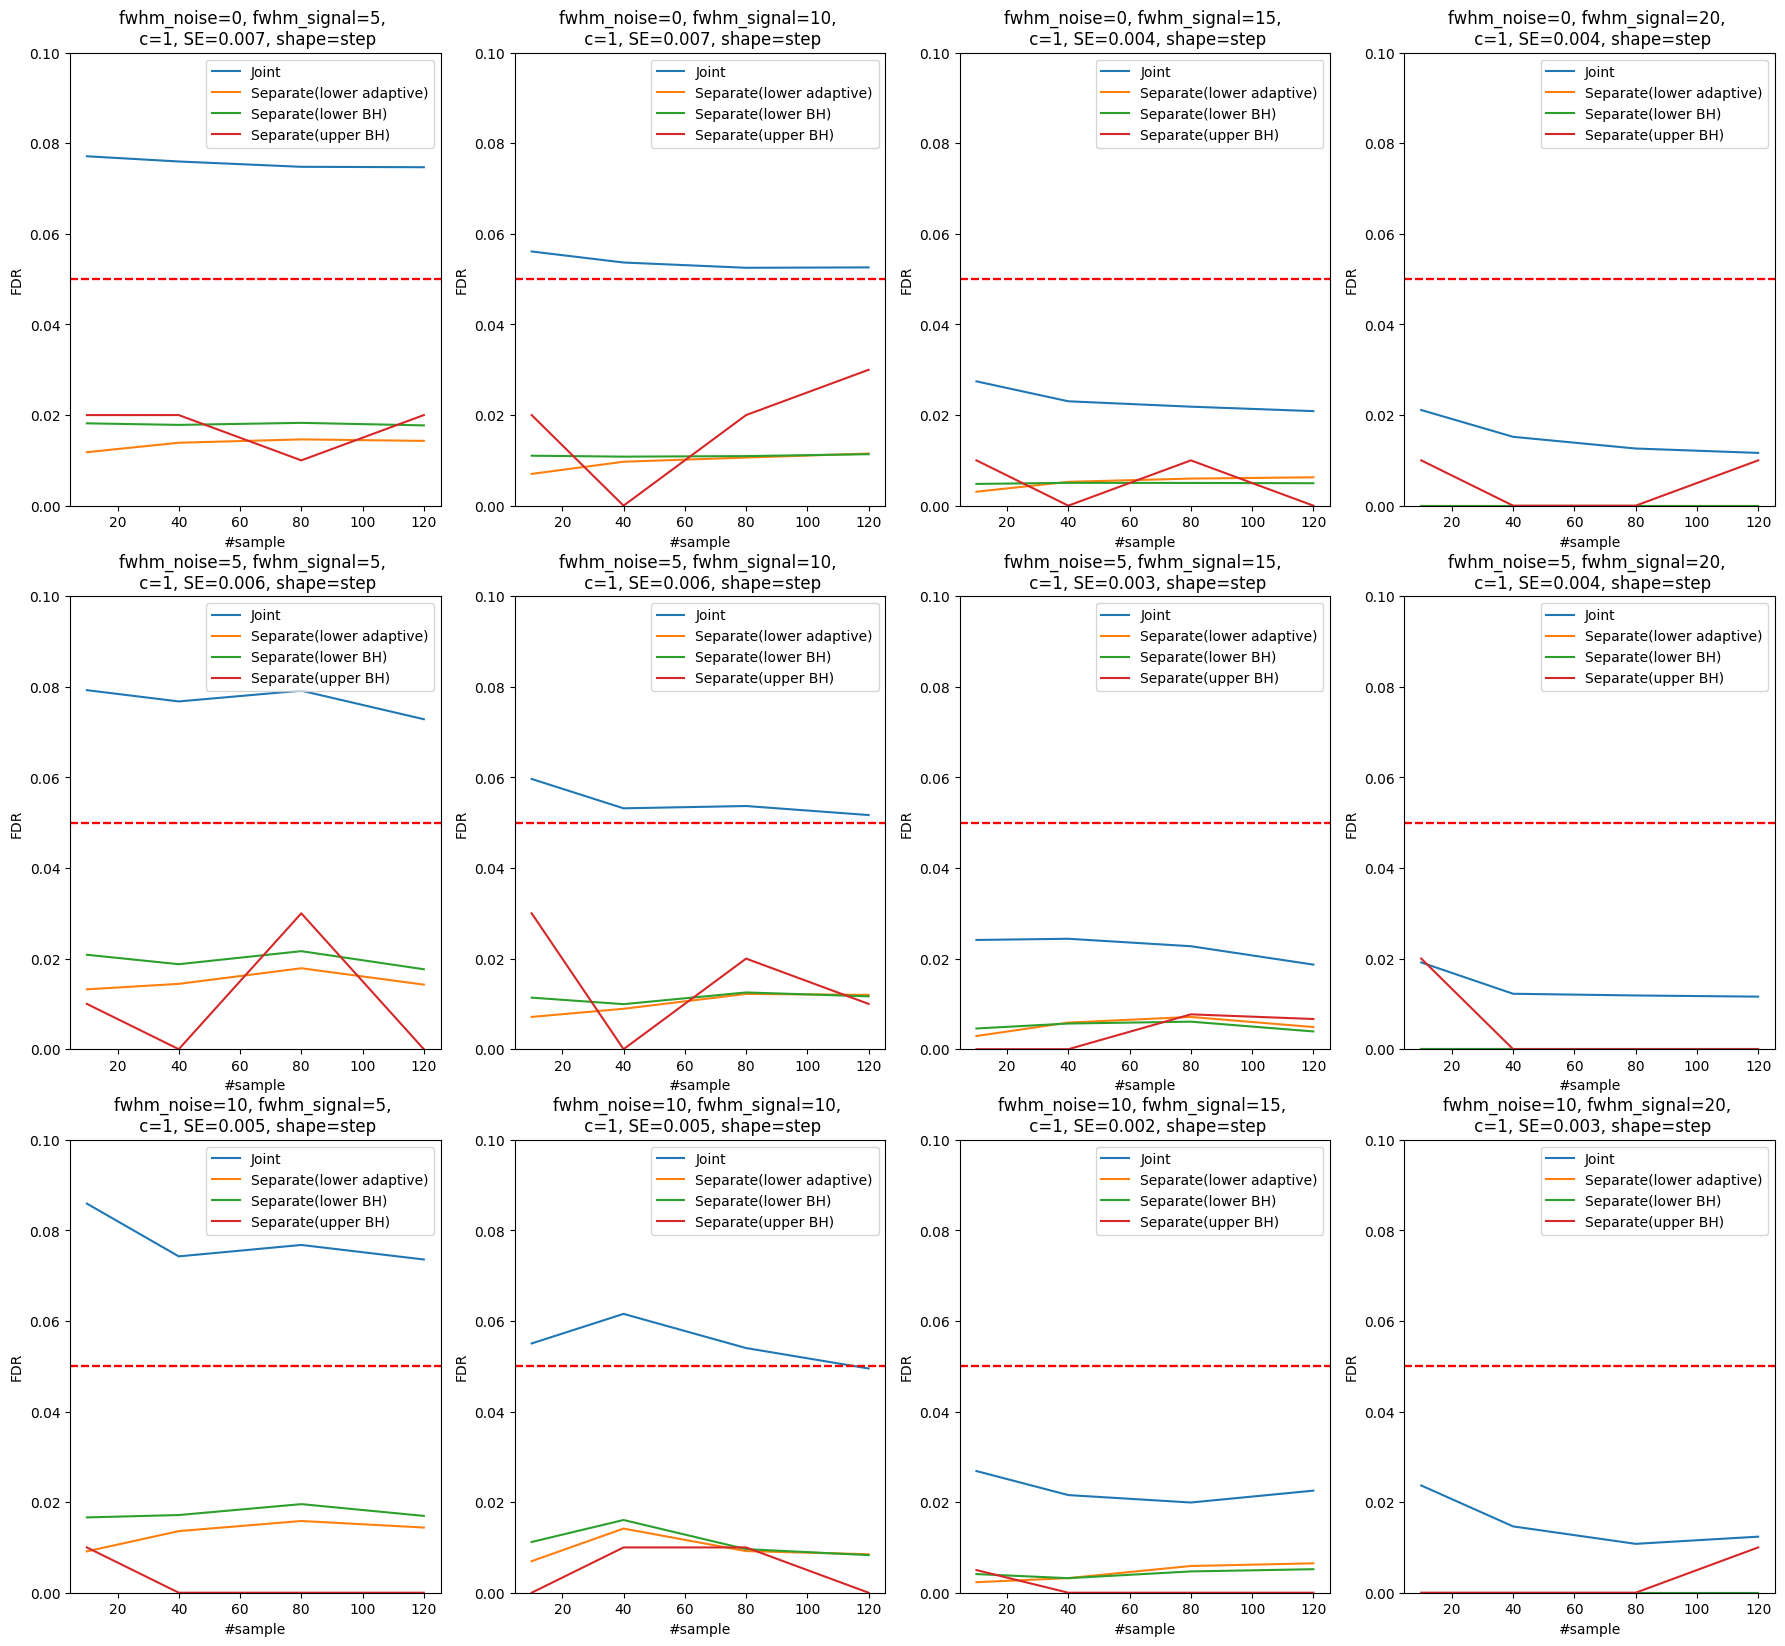

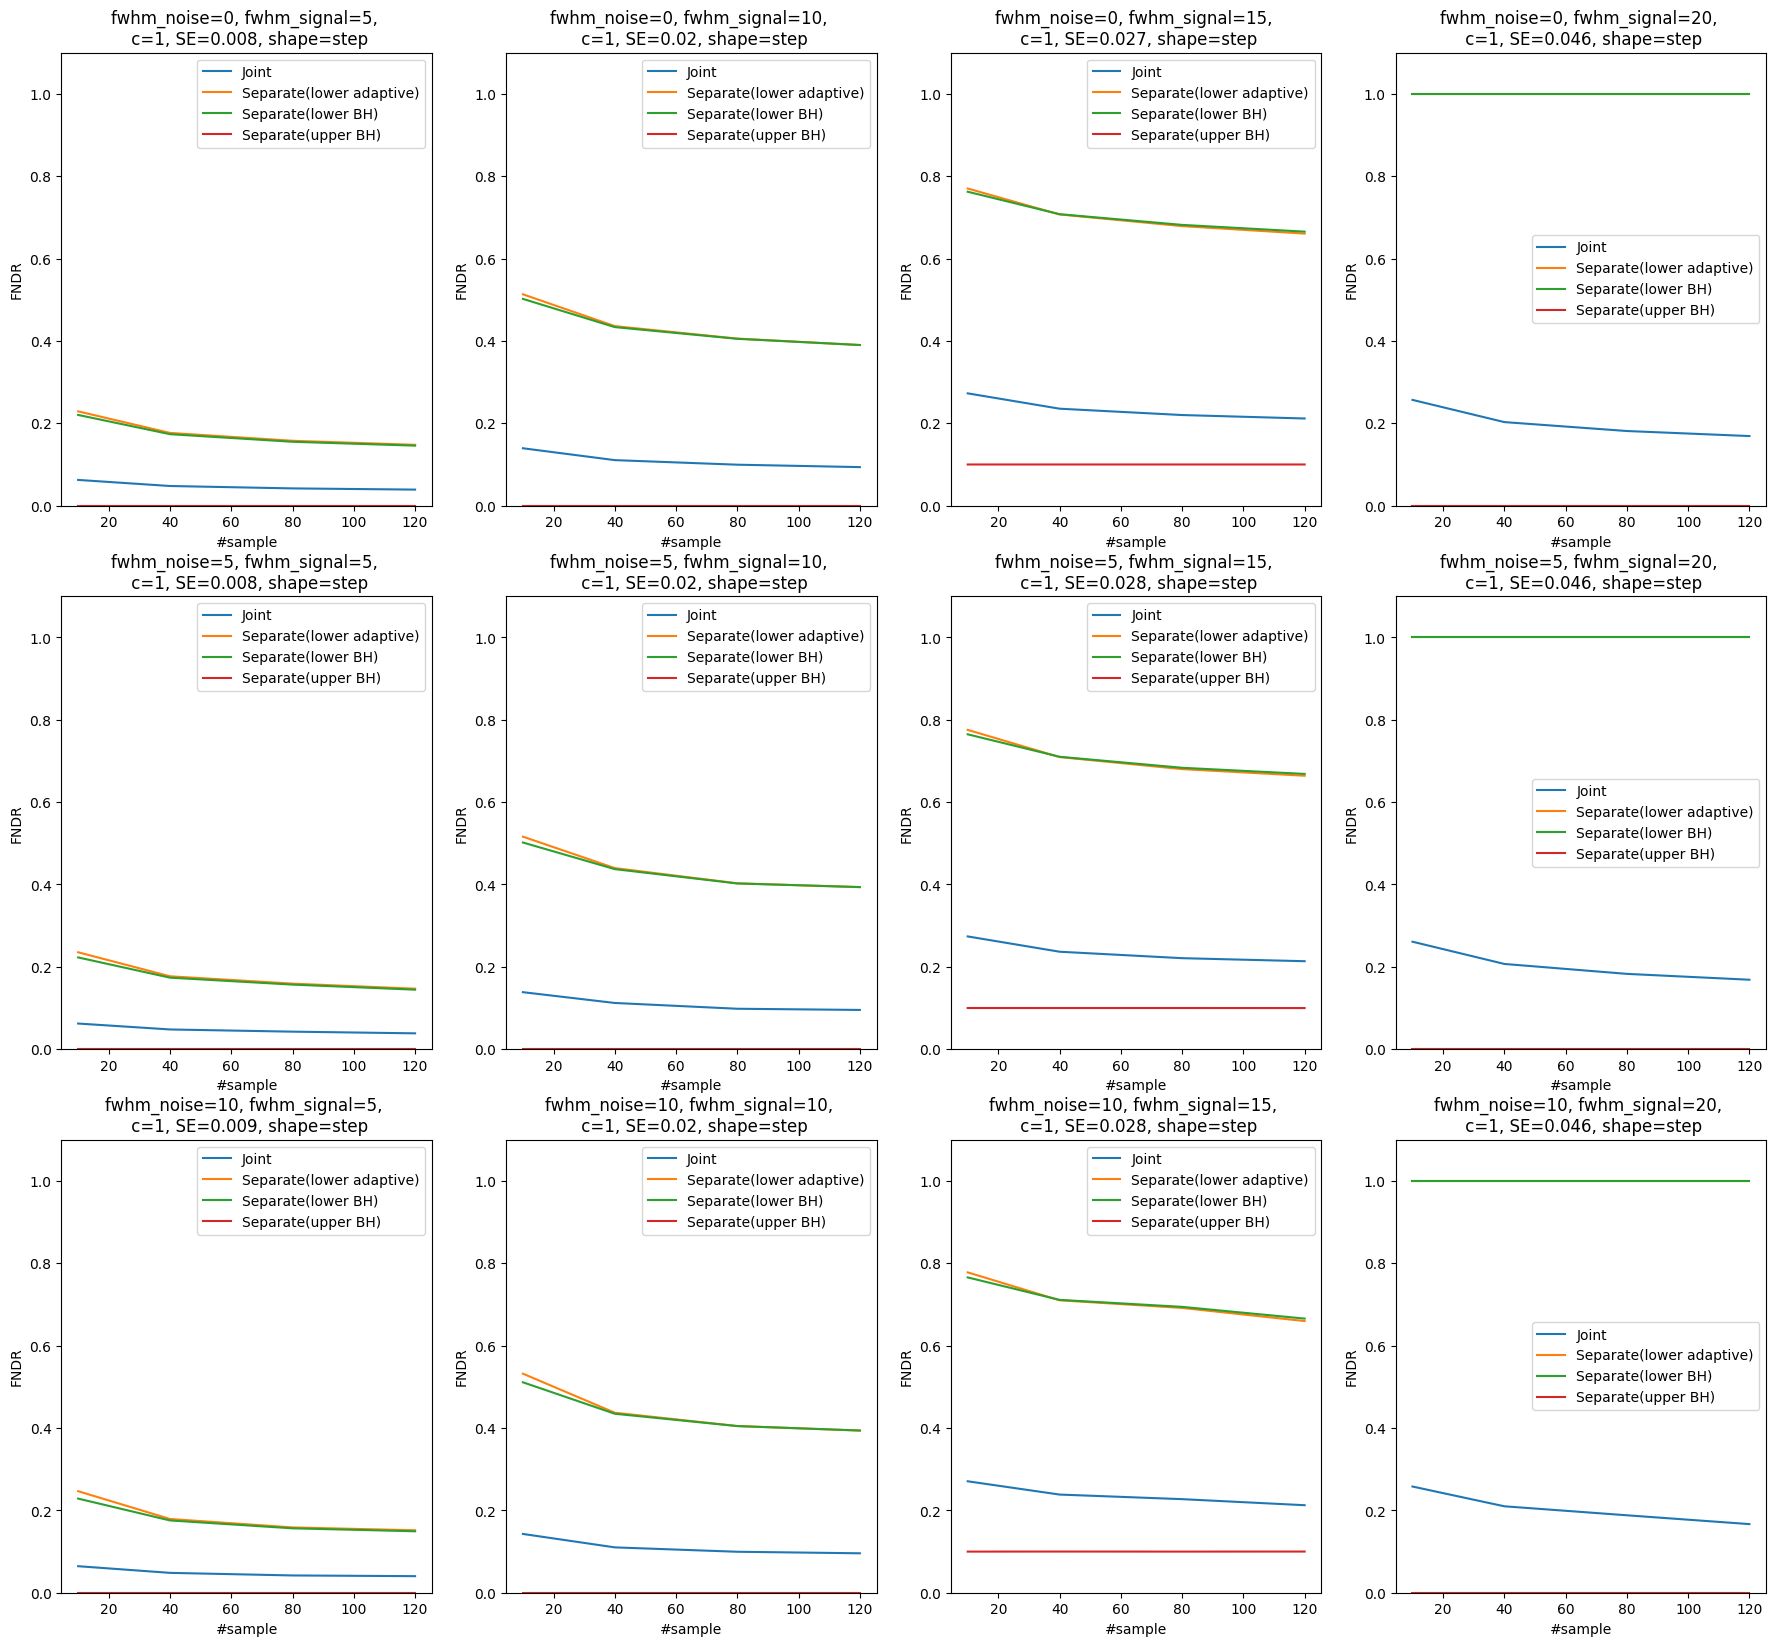

In [ ]:
fwhm_signal_vec = [5, 10, 15, 20]
fwhm_noise_vec = [0, 5, 10]
sim_num = 100
sim_plot_n(sim_num=sim_num, n_vec=[10,40,80,120], mode="FDR", threshold=1, shape="step",
                   fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec, std=1,
                       c_marg=0.2,  alpha=0.05, alpha0=0.05/4, alpha1=0.05/2, figsize=(22, 20))
sim_plot_n(sim_num=sim_num, n_vec=[10,40,80,120], mode="FNDR", threshold=1, shape="step",
                   fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec, std=1,
                       c_marg=0.2,  alpha=0.05, alpha0=0.05/4, alpha1=0.05/2, figsize=(22, 20))

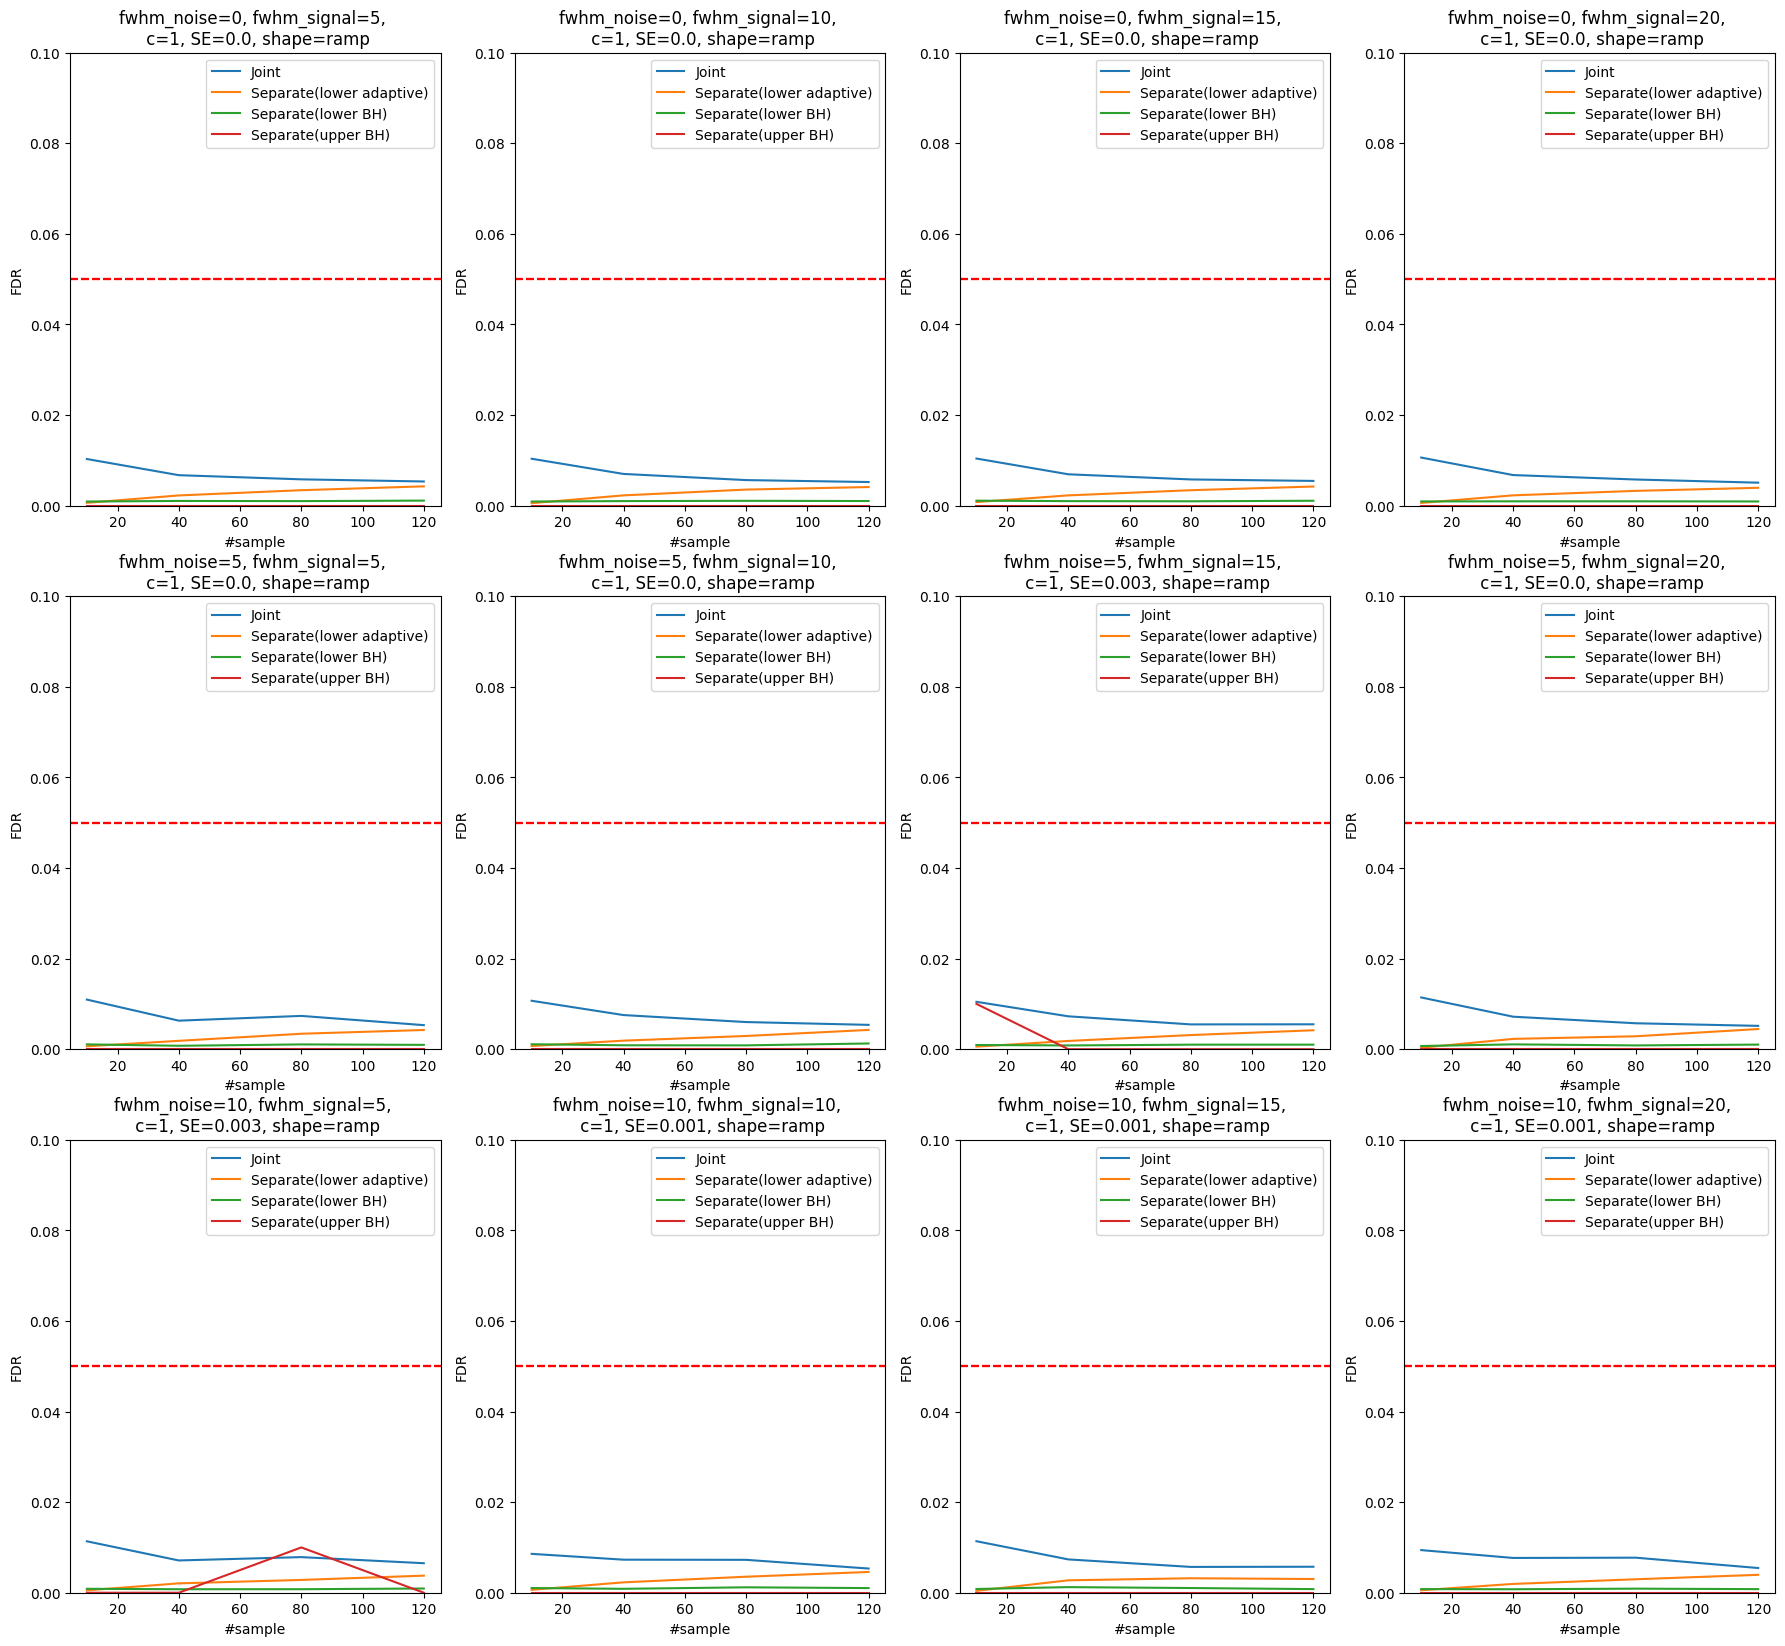

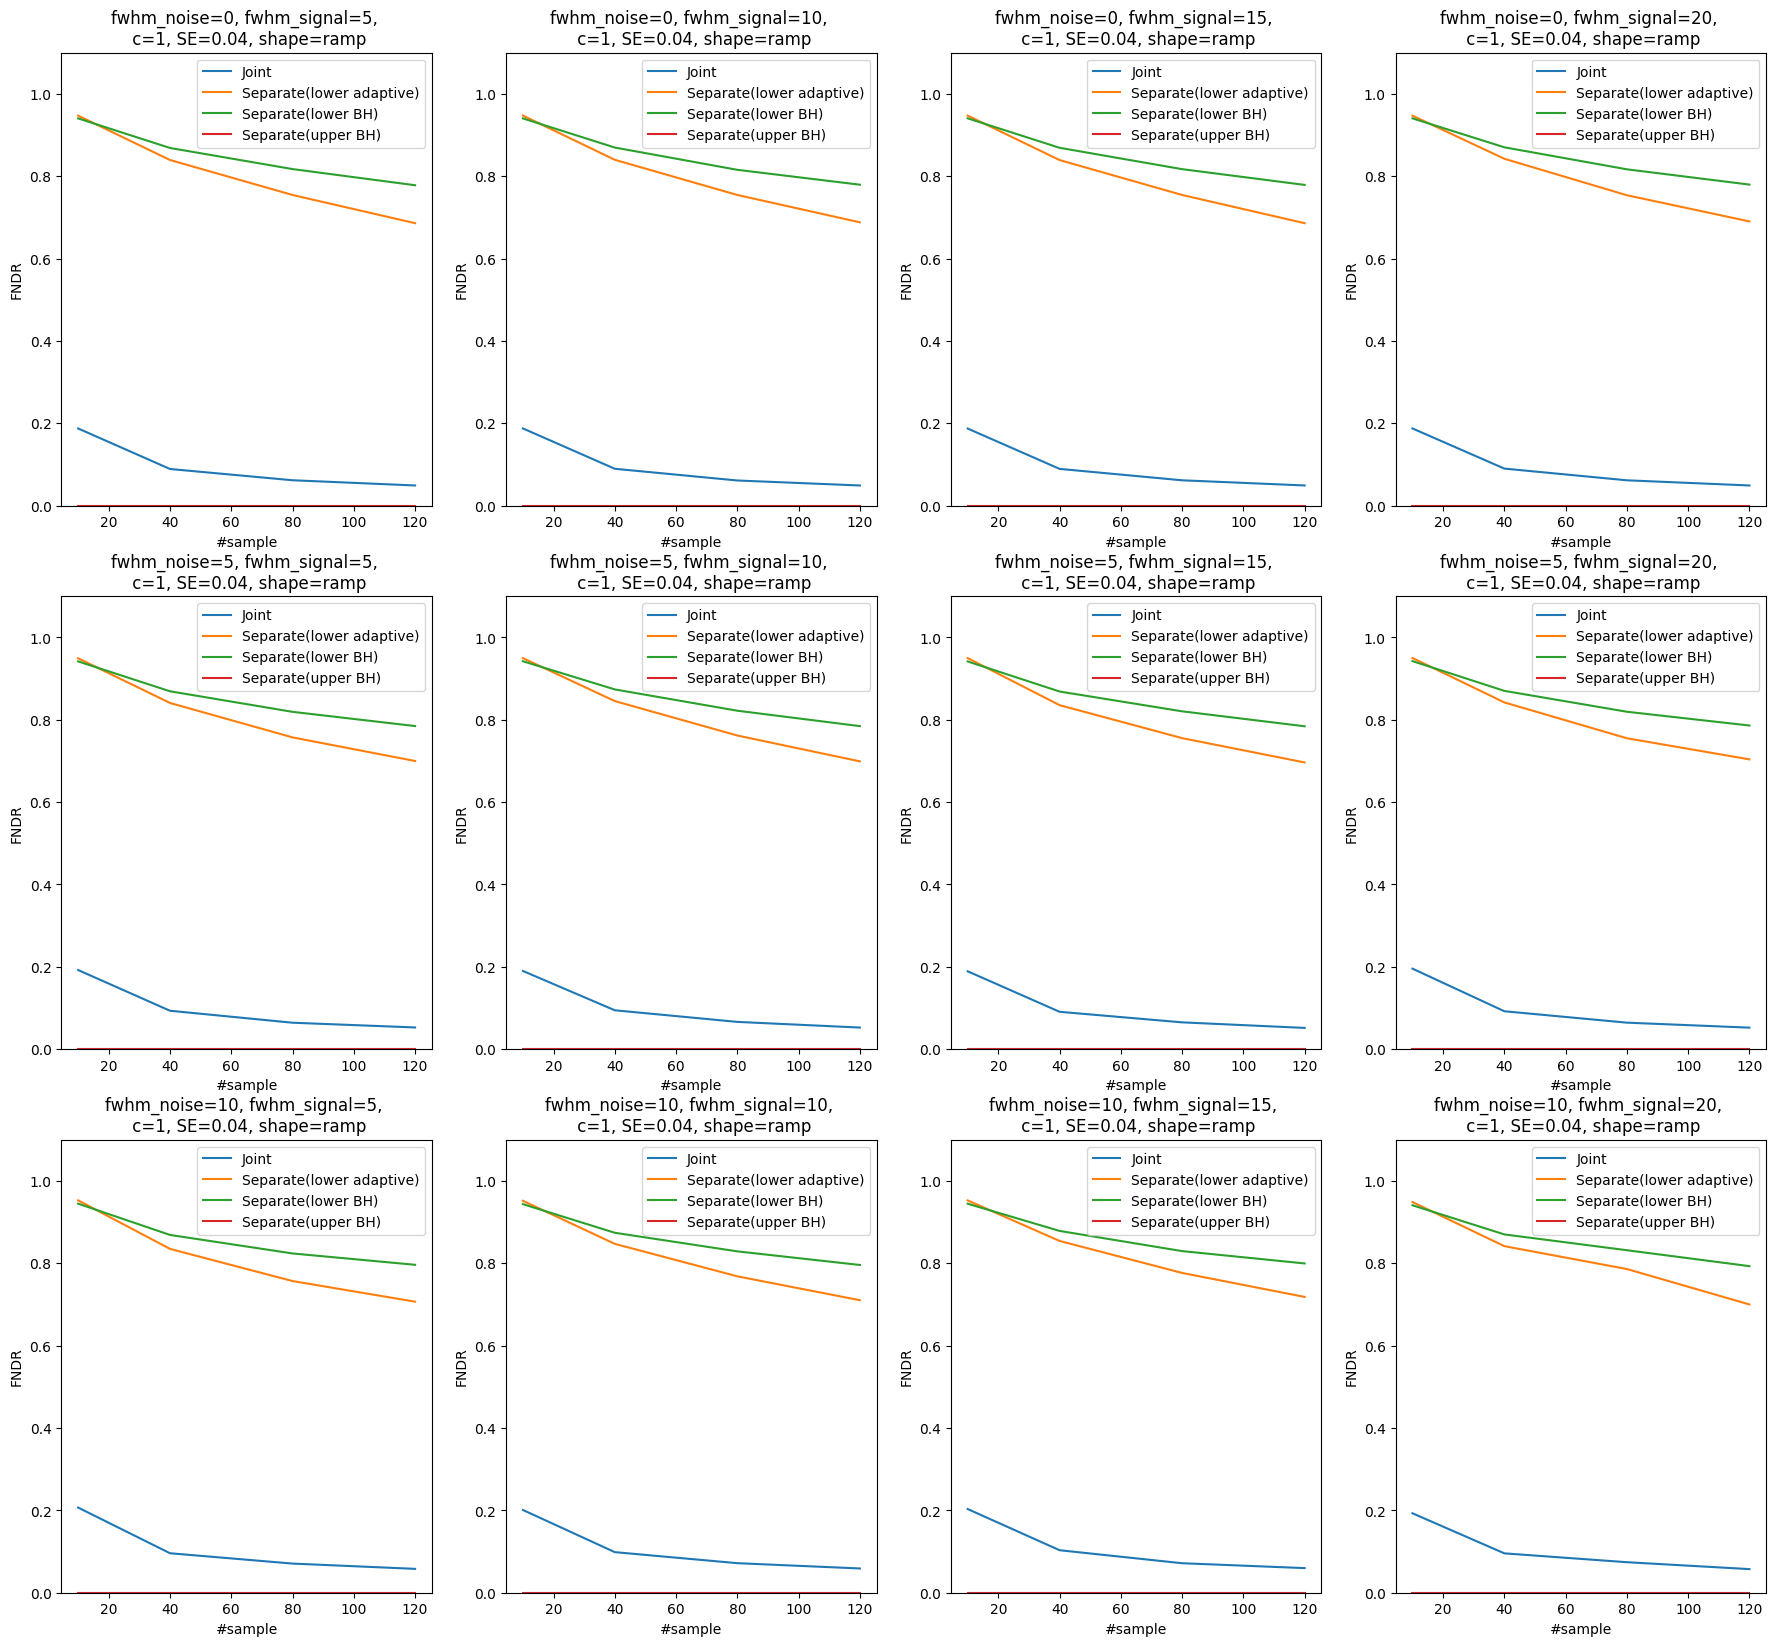

In [ ]:
fwhm_signal_vec = [5, 10, 15, 20]
fwhm_noise_vec = [0, 5, 10]
sim_num = 100
sim_plot_n(sim_num=sim_num, n_vec=[10,40,80,120], mode="FDR", threshold=1, shape="ramp",
                   fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec, std=1,
                       c_marg=0.2,  alpha=0.05, alpha0=0.05/4, alpha1=0.05/2, figsize=(22, 20))
sim_plot_n(sim_num=sim_num, n_vec=[10,40,80,120], mode="FNDR", threshold=1, shape="ramp",
                   fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec, std=1,
                       c_marg=0.2,  alpha=0.05, alpha0=0.05/4, alpha1=0.05/2, figsize=(22, 20))

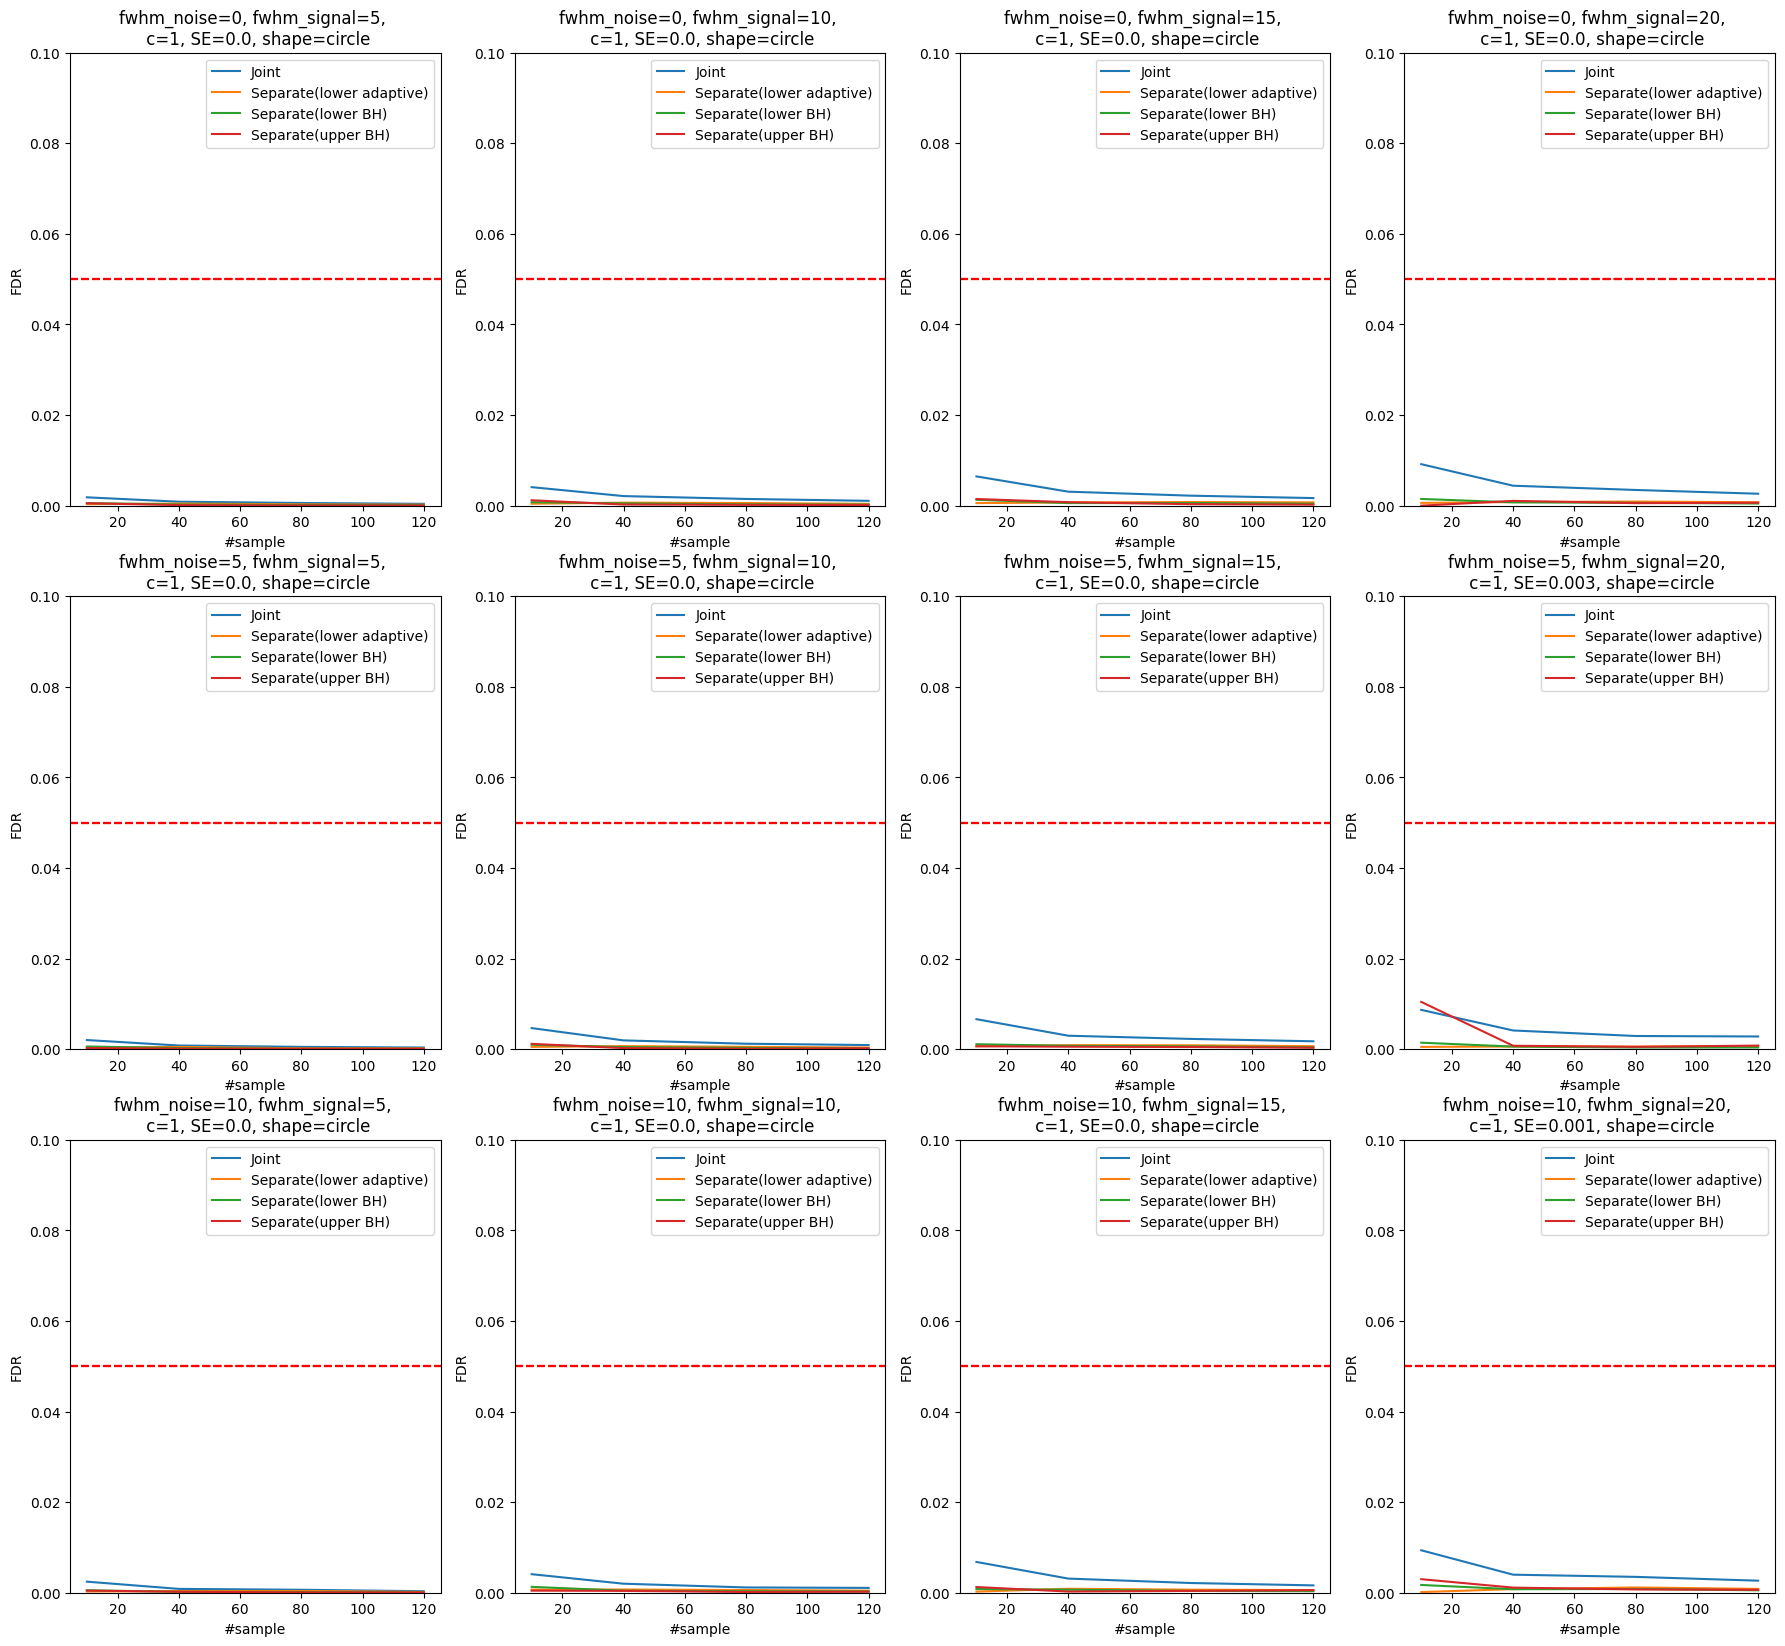

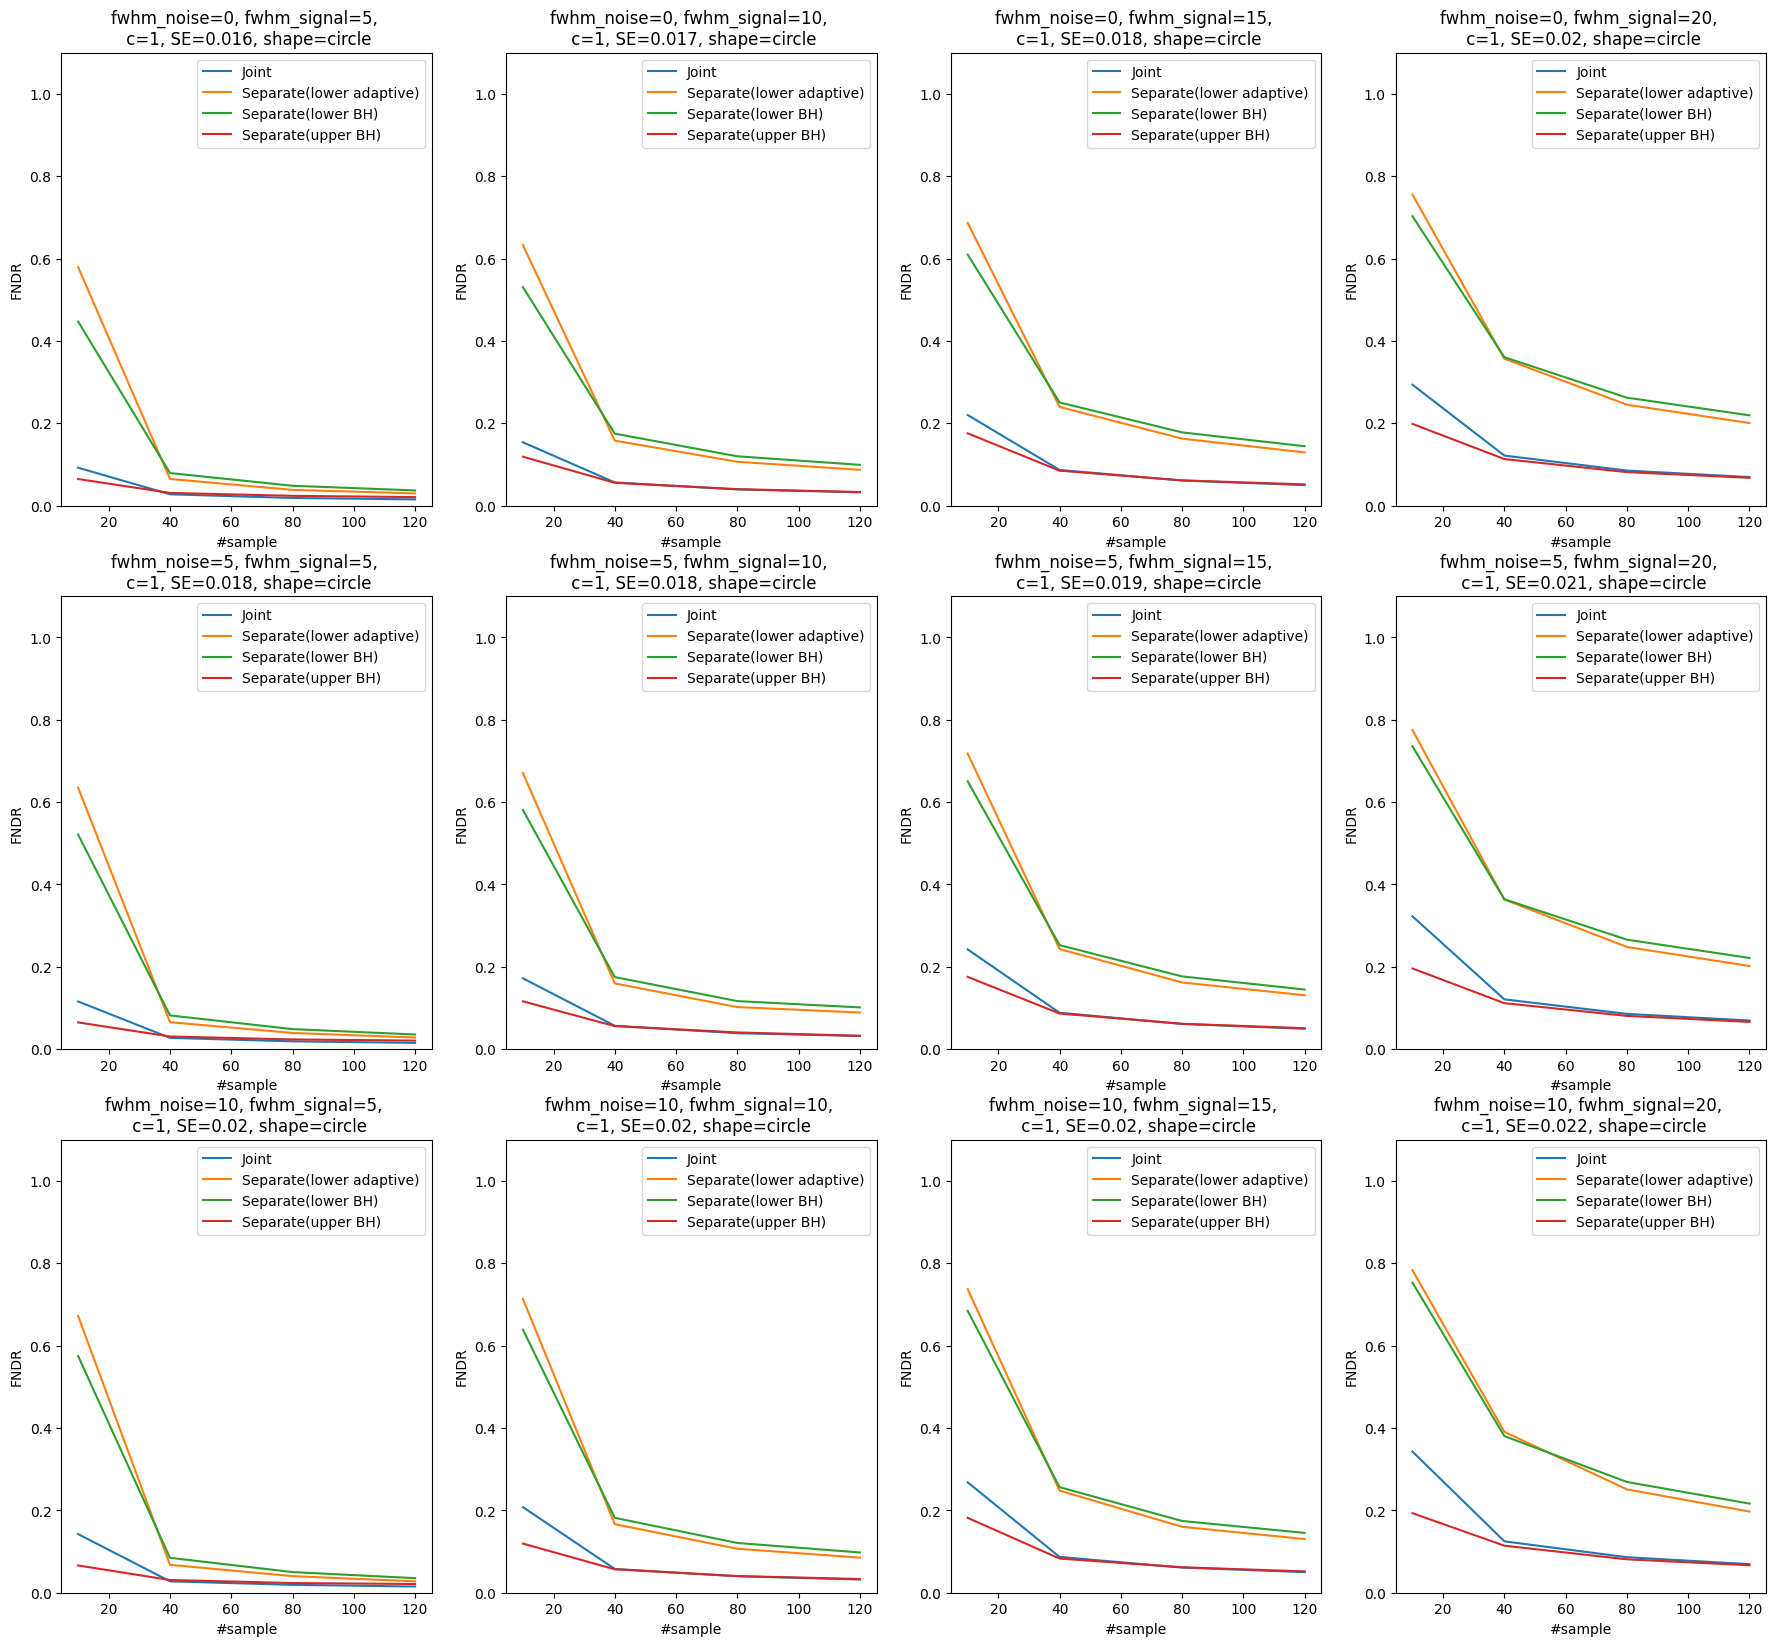

In [ ]:
fwhm_signal_vec = [5, 10, 15, 20]
fwhm_noise_vec = [0, 5, 10]
sim_num = 100
sim_plot_n(sim_num=sim_num, n_vec=[10,40,80,120], mode="FDR", threshold=1, shape="circle",
                   fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec, std=1,
                       c_marg=0.2,  alpha=0.05, alpha0=0.05/4, alpha1=0.05/2, figsize=(22, 20))
sim_plot_n(sim_num=sim_num, n_vec=[10,40,80,120], mode="FNDR", threshold=1, shape="circle",
                   fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec, std=1,
                       c_marg=0.2,  alpha=0.05, alpha0=0.05/4, alpha1=0.05/2, figsize=(22, 20))

# Real World Data Application

In [42]:
import sanssouci as ss
import nilearn
import nibabel as nib

import pyperm as pr

from nilearn.image import get_data, load_img
from nilearn.input_data import NiftiMasker

ModuleNotFoundError: No module named 'sanssouci'

In [ ]:
import requests
import zipfile
import pandas as pd
import glob
import os

def download_and_extract_zip_from_dropbox(local_path):

    url = 'https://www.dropbox.com/s/ukpxm38n0tzbw5q/HCP_U77_WM.zip?dl=1'

    # Download the zip file from Dropbox
    response = requests.get(url, allow_redirects=True)

    # Save the zip file
    zip_file_path = local_path + '.zip'

    # Write the zip file to the local path
    open(zip_file_path, 'wb').write(response.content)

    # Extract the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(local_path)

    # Remove the zip file
    os.remove(zip_file_path)

    # List all nifti files in the directory
    bold_files = glob.glob(os.path.join(local_path,'HCP_U77_WM','*.nii.gz'))

    # Now sort the bold files
    bold_files = sorted(bold_files, key=lambda name: int(os.path.basename(name).split('_')[0]))

    # Read in the covariate data
    covariates = pd.read_csv(os.path.join(local_path,'HCP_U77_WM','behavioural_data_subset_77.csv'))

    # Sort dataframe by 'Subject'
    covariates = covariates.sort_values(by='Subject')

    return(bold_files, covariates)

## Load Image

In [ ]:
# Real data directory
data_dir = os.path.join('/Users/howonryu/Projects/ConfidenceSet/ConfidenceSet/','data')
real_data_dir = os.path.join('/Users/howonryu/Projects/ConfidenceSet/ConfidenceSet/','data','example_real_data')

bold_files, covariates = download_and_extract_zip_from_dropbox(real_data_dir)
data_loc = real_data_dir + '/HCP_U77_WM/'


In [ ]:
# Only need to run if you already had the data downloaded:
data_loc = real_data_dir + '/HCP_U77_WM/'
bold_files = pr.list_files(data_loc, '.nii.gz', 1)


### Explore one image

In [ ]:
img = nib.load('/Users/howonryu/Projects/ConfidenceSet/ConfidenceSet/data/example_real_data/HCP_U77_WM/100307_WM_Level2_cope11feat_cope1.nii.gz')
mask_img = nib.load('/Users/howonryu/Projects/ConfidenceSet/ConfidenceSet/data/mask_GM_forFunc.nii')

# Get the image data and header information
img_data = img.get_fdata()
img_header = img.header

# Apply the mask
masker = NiftiMasker(smoothing_fwhm=fwhm, mask_img=mask_img).fit()
masked_data = masker.transform(img)

# Display some information about the masked data
print("Original Image shape:", img_data.shape)
print("Masked Image shape:", masked_data.shape)
print("Voxel dimensions:", img_header.get_zooms())


plt.imshow(img_data[:,:,70])
plt.colorbar()
plt.show()

### Load all images

In [ ]:
# file names
folder_path = "/Users/howonryu/Projects/ConfidenceSet/ConfidenceSet/data/example_real_data/HCP_U77_WM"
file_list = [f for f in os.listdir(folder_path) if f.endswith('.nii.gz')]

# mask
fwhm=5
mask_img = nib.load('/Users/howonryu/Projects/ConfidenceSet/ConfidenceSet/data/MNImask.nii')
masker = NiftiMasker(smoothing_fwhm=fwhm, mask_img=mask_img).fit()


img_data_stack = np.empty((91, 109, 91, len(file_list)))
masked_data_stack = np.empty((1, 228483, len(file_list)))

# Load each file and append it to the list
for i, file_name in enumerate(file_list):
    file_path = os.path.join(folder_path, file_name)
    img = nib.load(file_path)
    img_data = img.get_fdata()
    masked_data = masker.transform(img)

    img_data_stack[:,:,:,i] = img_data
    masked_data_stack[:,:,i] = masked_data
masked_data_stack_unsqueezed = masked_data_stack[0,:,:]


print(img_data_stack.shape)
print(masked_data_stack.shape)
print(masked_data_stack_unsqueezed.shape)



## Confidence Set Appllication

In [ ]:
data_field = np.transpose(data_back[:,:,33,:], (2, 0, 1))
print(data_field.shape)

plt.imshow(data_field[5,:,:])
plt.colorbar()
plt.show()

In [ ]:
cmap1 = colors.ListedColormap(['none', 'blue'])
cmap2 = colors.ListedColormap(['none', 'yellow'])
cmap3 = colors.ListedColormap(['none', 'red'])

fig, axs = plt.subplots(1,4, figsize=(20,10))

im = axs[0].imshow(data_field.mean(axis=0))
im = axs[0].set_title(f"mean across subjects (the 33rd axial)")


c = 5
alpha = 0.05
method = "separate_BH"
lower_set, upper_set, Achat, plot_add, n_rej = fdr_confset(data_field, threshold=c, method=method, alpha=alpha,
             k=2, alpha0=0.05 / 4, alpha1=0.05 / 2)

im = axs[1].imshow(data_field.mean(axis=0))
im = axs[1].imshow(lower_set, cmap=cmap1)
im = axs[1].imshow(Achat, cmap=cmap2)
im = axs[1].imshow(upper_set, cmap=cmap3)
im = axs[1].set_title(f"{method}, alpha={alpha}, threshold={c}")


method = "separate_adaptive"
lower_set, upper_set, Achat, plot_add, n_rej = fdr_confset(data_field, threshold=c, method=method, alpha=alpha,
             k=2, alpha0=0.05 / 4, alpha1=0.05 / 2)

im = axs[2].imshow(data_field.mean(axis=0))
im = axs[2].imshow(lower_set, cmap=cmap1)
im = axs[2].imshow(Achat, cmap=cmap2)
im = axs[2].imshow(upper_set, cmap=cmap3)
im = axs[2].set_title(f"{method}, alpha={alpha}, threshold={c}")



method = "joint"
lower_set, upper_set, Achat, plot_add, n_rej = fdr_confset(data_field, threshold=c, method=method, alpha=alpha,
             k=2, alpha0=0.05 / 4, alpha1=0.05 / 2)

im = axs[3].imshow(data_field.mean(axis=0))
im = axs[3].imshow(lower_set, cmap=cmap1)
im = axs[3].imshow(Achat, cmap=cmap2)
im = axs[3].imshow(upper_set, cmap=cmap3)
im = axs[3].set_title(f"{method}, alpha={alpha}, threshold={c}")


plt.show()